# TIME SERIES

## Tabla de contenido

## Objetivos

## Librerías necesarias

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
#import keras_tuner
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import csv
from datetime import datetime

## Helper fucntions

In [3]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None 
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

## Carga de datos

Descargamos los datos de https://www.coindesk.com/price/bitcoin/

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2023-12-12 15:30:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[2606:50c0:8003::154]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 178509 (174K) [text/plain]
Guardando como: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.2’

BTC_USD_2013-10-01_ 100%[===================>] 174,33K   878KB/s    en 0,2s    

2023-12-12 15:30:47 (878 KB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.2’ guardado [178509/178509]



In [5]:
!ls

 10_time_series_forecasting_in_tensorflow.ipynb
 10_time_series_forecasting_with_tensorflow_video.ipynb
'Bitcoin price prediction.ipynb'
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.2
 model_experiments


In [6]:
# importamos los datos con pandas

df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [8]:
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seaonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.


-> afinar la definición

In [9]:
# Only want closing price for each day
# me quedo sólo con lo que preciso y hago un rename
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


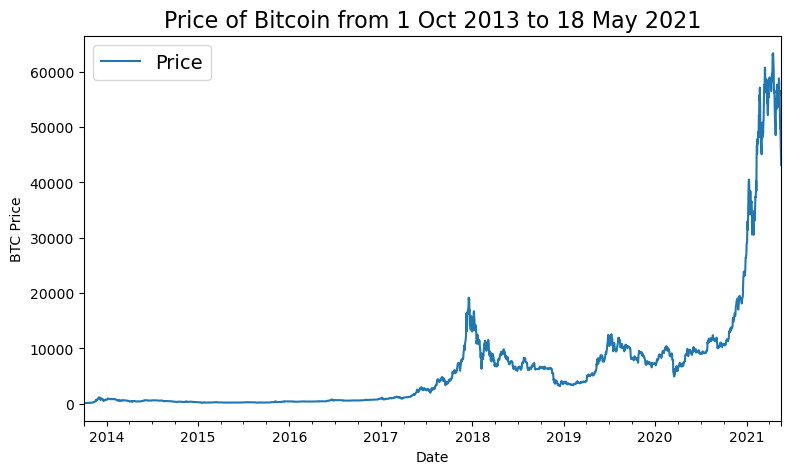

In [10]:
bitcoin_prices.plot(figsize=(9, 5))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

<b>Importando los datos usando el módulo CSV reader de python</b> (una alternativa a usar Pandas)

In [11]:
# Importing and formatting historical Bitcoin data with Python
timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

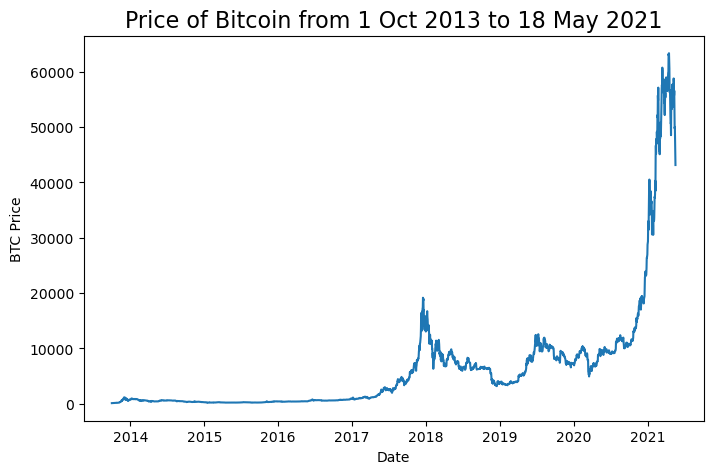

In [12]:
plt.figure(figsize=(8,5))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

### Train test split

NO puedo usar train_test_split de sklearn así nomás, pues hace una división aleatoria y esto es una serie temporal; el orden importa!!!

In [13]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [14]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

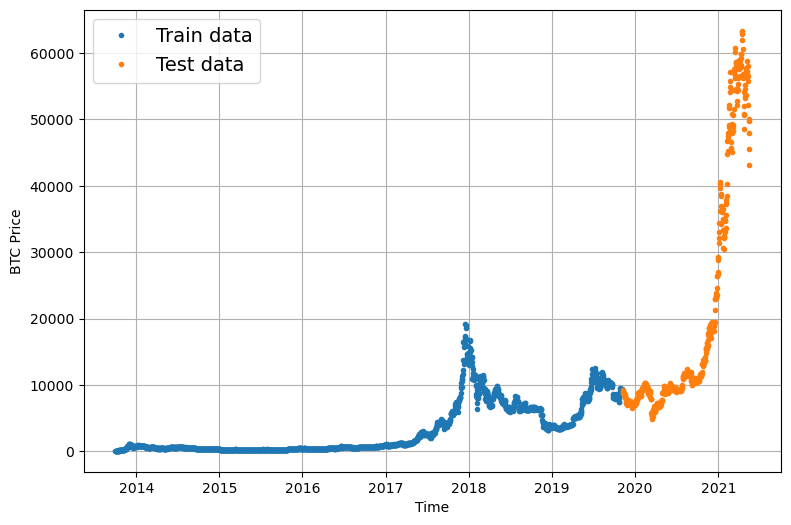

In [15]:
# Test out plotting function
plt.figure(figsize=(9, 6))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelos a probar

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0	Naïve model (baseline)	
* 1	Dense model, horizon = 1, window = 7
* 2	Same as 1, 	horizon = 1, window = 30
* 3	Same as 1, 	horizon = 7, window =	30
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)

<b> <font color='green'>Naive Forecast</font></b>

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [16]:
# Create a naive forecast 
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

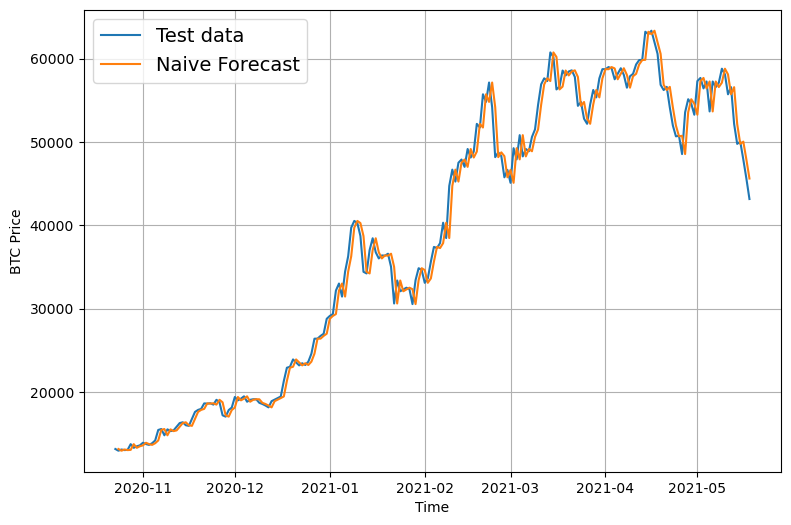

In [17]:
# Plot naive forecast
plt.figure(figsize=(9, 6))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive Forecast")

## Evaluando series temporales

Let's look into some evaluation metrics for time series forecasting. 

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html) 

<b> Implementando MASE </b>

In [18]:
# repaso reduce_mean

"""
tf.math.reduce_mean(
    input_tensor, axis=None, keepdims=False, name=None
)
"""

x = tf.constant( [ [1., 2.], [5.,3.] ])

print(x)

print(tf.math.reduce_mean(x)) # (1+2+5+3)/4  -> 2.75

print(tf.math.reduce_mean(x,axis=0)) # (1+5)/2 ; (2+3)/2

print(tf.math.reduce_mean(x,axis=1)) # (1+2)/2 ; (5+3)/2

print(tf.math.reduce_mean(x,axis=1,keepdims=True)) 

tf.Tensor(
[[1. 2.]
 [5. 3.]], shape=(2, 2), dtype=float32)
tf.Tensor(2.75, shape=(), dtype=float32)
tf.Tensor([3.  2.5], shape=(2,), dtype=float32)
tf.Tensor([1.5 4. ], shape=(2,), dtype=float32)
tf.Tensor(
[[1.5]
 [4. ]], shape=(2, 1), dtype=float32)


In [19]:
# ayuda para lo que sigue

y = np.array([1, 4, 7])


# yt - ty-1 : -> (7-4), (4-1)


print(y[1:]) # es desde la primera porque en la atrasada no tengo con qué restar al inicio
print(y[:-1])

y[1:] - y[:-1]



[4 7]
[1 4]


array([3, 3])

In [20]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [21]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

Función para computar las distintas métricas

In [22]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [23]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## <font color='#9400D3'> Format Data Part 2: Windowing our dataset </font>


--> antes usamos train/dev/test, ahora usaremos ventanas


Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [24]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [25]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [26]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite lsow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon 

> 📖 **Resource:** The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [28]:
# Ayuda de código


window_size = 3
horizon = 1


aux = np.array([10, 11, 12, 13, 14])


print(f"aux {aux}\n")


window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)


print(f"window step: {window_step}\n")

window_indexes = window_step + np.expand_dims(np.arange(len(aux)-(window_size+horizon-1)), axis=0).T 


print(f"window indexes {window_indexes}")


aux[window_indexes]




#aux[[[0,1,2,3],[1,2,3,4]]]


aux [10 11 12 13 14]

window step: [[0 1 2 3]]

window indexes [[0 1 2 3]
 [1 2 3 4]]


array([[10, 11, 12, 13],
       [11, 12, 13, 14]])

In [29]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    #print(f"entrada: {x}\n")


    # 1. Create a window of specific window_size (add the horzion on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)


    print(f"window setp: {window_step}\n")


    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
        # create 2D array of windows of size window_size
        # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # np.arange(4) -> [0,1,2,3]
    """
    np.expand_dims(np.arange(4),axis=0).T + [[1]]
    array([[1],
           [2],
           [3],
           [4]])
    """
        
        
        
    #print(f"window_indexes: {window_indexes}\n")


    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]


    #print(f"windowed_array: {windowed_array}\n")


    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [30]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

window setp: [[0 1 2 3 4 5 6 7]]



(2780, 2780)

In [31]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


> 🔑 **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array 

In [32]:
"""
tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None
)
"""


"""

La exploraré primero sólo con las entradas y leugo tmb. con los targets

"""




window_size = 3
horizon = 1
data = np.array([10, 11, 12, 13, 14])


aux = tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets=None,
    sequence_length=window_size,
    sequence_stride=horizon
)


for a in aux:
    print(a)




tf.Tensor(
[[10 11 12]
 [11 12 13]
 [12 13 14]], shape=(3, 3), dtype=int64)


In [33]:
aux = tf.keras.utils.timeseries_dataset_from_array(
    prices,
    targets=None,
    sequence_length=WINDOW_SIZE,
    sequence_stride=HORIZON
)

for a in aux:
    print(a)
    

tf.Tensor(
[[ 123.65499  125.455    108.58483  118.67466  121.33866  120.65533
   121.795  ]
 [ 125.455    108.58483  118.67466  121.33866  120.65533  121.795
   123.033  ]
 [ 108.58483  118.67466  121.33866  120.65533  121.795    123.033
   124.049  ]
 [ 118.67466  121.33866  120.65533  121.795    123.033    124.049
   125.96116]
 [ 121.33866  120.65533  121.795    123.033    124.049    125.96116
   125.27966]
 [ 120.65533  121.795    123.033    124.049    125.96116  125.27966
   125.9275 ]
 [ 121.795    123.033    124.049    125.96116  125.27966  125.9275
   126.38333]
 [ 123.033    124.049    125.96116  125.27966  125.9275   126.38333
   135.24199]
 [ 124.049    125.96116  125.27966  125.9275   126.38333  135.24199
   133.20333]
 [ 125.96116  125.27966  125.9275   126.38333  135.24199  133.20333
   142.76333]
 [ 125.27966  125.9275   126.38333  135.24199  133.20333  142.76333
   137.92333]
 [ 125.9275   126.38333  135.24199  133.20333  142.76333  137.92333
   142.95166]
 [ 126.38333

tf.Tensor(
[[802.75333 748.43559 692.66914 668.86463 700.44843 694.3125  665.7975 ]
 [748.43559 692.66914 668.86463 700.44843 694.3125  665.7975  645.615  ]
 [692.66914 668.86463 700.44843 694.3125  665.7975  645.615   578.4125 ]
 [668.86463 700.44843 694.3125  665.7975  645.615   578.4125  641.91   ]
 [700.44843 694.3125  665.7975  645.615   578.4125  641.91    656.2725 ]
 [694.3125  665.7975  645.615   578.4125  641.91    656.2725  611.04499]
 [665.7975  645.615   578.4125  641.91    656.2725  611.04499 634.99   ]
 [645.615   578.4125  641.91    656.2725  611.04499 634.99    618.79   ]
 [578.4125  641.91    656.2725  611.04499 634.99    618.79    619.8425 ]
 [641.91    656.2725  611.04499 634.99    618.79    619.8425  545.7625 ]
 [656.2725  611.04499 634.99    618.79    619.8425  545.7625  561.535  ]
 [611.04499 634.99    618.79    619.8425  545.7625  561.535   622.22   ]
 [634.99    618.79    619.8425  545.7625  561.535   622.22    572.7675 ]
 [618.79    619.8425  545.7625  561.535 

tf.Tensor(
[[238.15225 235.67716 251.28908 251.03416 251.9314  258.8485  270.7625 ]
 [235.67716 251.28908 251.03416 251.9314  258.8485  270.7625  278.1172 ]
 [251.28908 251.03416 251.9314  258.8485  270.7625  278.1172  269.2606 ]
 [251.03416 251.9314  258.8485  270.7625  278.1172  269.2606  274.8977 ]
 [251.9314  258.8485  270.7625  278.1172  269.2606  274.8977  270.86109]
 [258.8485  270.7625  278.1172  269.2606  274.8977  270.86109 276.72789]
 [270.7625  278.1172  269.2606  274.8977  270.86109 276.72789 277.98519]
 [278.1172  269.2606  274.8977  270.86109 276.72789 277.98519 294.1886 ]
 [269.2606  274.8977  270.86109 276.72789 277.98519 294.1886  289.7149 ]
 [274.8977  270.86109 276.72789 277.98519 294.1886  289.7149  292.8678 ]
 [270.86109 276.72789 277.98519 294.1886  289.7149  292.8678  293.224  ]
 [276.72789 277.98519 294.1886  289.7149  292.8678  293.224   282.644  ]
 [277.98519 294.1886  289.7149  292.8678  293.224   282.644   283.0809 ]
 [294.1886  289.7149  292.8678  293.224 

 [259.62937 255.52675 253.87887 261.42899 267.60762 270.07587 264.356  ]], shape=(128, 7), dtype=float64)
tf.Tensor(
[[255.52675 253.87887 261.42899 267.60762 270.07587 264.356   267.943  ]
 [253.87887 261.42899 267.60762 270.07587 264.356   267.943   269.24925]
 [261.42899 267.60762 270.07587 264.356   267.943   269.24925 286.53662]
 [267.60762 270.07587 264.356   267.943   269.24925 286.53662 301.03837]
 [270.07587 264.356   267.943   269.24925 286.53662 301.03837 304.9905 ]
 [264.356   267.943   269.24925 286.53662 301.03837 304.9905  290.93137]
 [267.943   269.24925 286.53662 301.03837 304.9905  290.93137 288.48787]
 [269.24925 286.53662 301.03837 304.9905  290.93137 288.48787 287.55762]
 [286.53662 301.03837 304.9905  290.93137 288.48787 287.55762 276.97924]
 [301.03837 304.9905  290.93137 288.48787 287.55762 276.97924 278.33337]
 [304.9905  290.93137 288.48787 287.55762 276.97924 278.33337 275.30687]
 [290.93137 288.48787 287.55762 276.97924 278.33337 275.30687 274.28387]
 [288.4

tf.Tensor(
[[387.775   370.652   376.948   311.702   320.036   337.893   334.125  ]
 [370.652   376.948   311.702   320.036   337.893   334.125   333.951  ]
 [376.948   311.702   320.036   337.893   334.125   333.951   320.06   ]
 [311.702   320.036   337.893   334.125   333.951   320.06    337.759  ]
 [320.036   337.893   334.125   333.951   320.06    337.759   333.33299]
 [337.893   334.125   333.951   320.06    337.759   333.33299 334.02499]
 [334.125   333.951   320.06    337.759   333.33299 334.02499 315.63099]
 [333.951   320.06    337.759   333.33299 334.02499 315.63099 321.482  ]
 [320.06    337.759   333.33299 334.02499 315.63099 321.482   326.365  ]
 [337.759   333.33299 334.02499 315.63099 321.482   326.365   322.606  ]
 [333.33299 334.02499 315.63099 321.482   326.365   322.606   320.993  ]
 [334.02499 315.63099 321.482   326.365   322.606   320.993   318.337  ]
 [315.63099 321.482   326.365   322.606   320.993   318.337   332.471  ]
 [321.482   326.365   322.606   320.993 

tf.Tensor(
[[662.034   666.747   654.725   654.895   660.284   655.418   650.82899]
 [666.747   654.725   654.895   660.284   655.418   650.82899 656.91599]
 [654.725   654.895   660.284   655.418   650.82899 656.91599 655.427  ]
 [654.895   660.284   655.418   650.82899 656.91599 655.427   656.681  ]
 [660.284   655.418   650.82899 656.91599 655.427   656.681   635.588  ]
 [655.418   650.82899 656.91599 655.427   656.681   635.588   621.37299]
 [650.82899 656.91599 655.427   656.681   635.588   621.37299 601.227  ]
 [656.91599 655.427   656.681   635.588   621.37299 601.227   555.926  ]
 [655.427   656.681   635.588   621.37299 601.227   555.926   578.52374]
 [656.681   635.588   621.37299 601.227   555.926   578.52374 570.33875]
 [635.588   621.37299 601.227   555.926   578.52374 570.33875 574.87375]
 [621.37299 601.227   555.926   578.52374 570.33875 574.87375 588.51625]
 [601.227   555.926   578.52374 570.33875 574.87375 588.51625 589.66125]
 [555.926   578.52374 570.33875 574.8737

tf.Tensor(
[[17221.65125 17436.5975  19166.97874 18640.2625  18984.7675  16862.57125
  16925.0175 ]
 [17436.5975  19166.97874 18640.2625  18984.7675  16862.57125 16925.0175
  14182.46499]
 [19166.97874 18640.2625  18984.7675  16862.57125 16925.0175  14182.46499
  14694.5825 ]
 [18640.2625  18984.7675  16862.57125 16925.0175  14182.46499 14694.5825
  14103.21875]
 [18984.7675  16862.57125 16925.0175  14182.46499 14694.5825  14103.21875
  13387.34875]
 [16862.57125 16925.0175  14182.46499 14694.5825  14103.21875 13387.34875
  14652.3675 ]
 [16925.0175  14182.46499 14694.5825  14103.21875 13387.34875 14652.3675
  15846.07375]
 [14182.46499 14694.5825  14103.21875 13387.34875 14652.3675  15846.07375
  14362.40375]
 [14694.5825  14103.21875 13387.34875 14652.3675  15846.07375 14362.40375
  14867.5725 ]
 [14103.21875 13387.34875 14652.3675  15846.07375 14362.40375 14867.5725
  13643.695  ]
 [13387.34875 14652.3675  15846.07375 14362.40375 14867.5725  13643.695
  13062.145  ]
 [14652.3675  15

tf.Tensor(
[[8830.05875    8868.16124    9191.82       9373.3025     8807.515
  9153.64125    9144.38375   ]
 [8868.16124    9191.82       9373.3025     8807.515      9153.64125
  9144.38375    9444.1425    ]
 [9191.82       9373.3025     8807.515      9153.64125    9144.38375
  9444.1425     9268.7175    ]
 [9373.3025     8807.515      9153.64125    9144.38375    9444.1425
  9268.7175     8949.87624   ]
 [8807.515      9153.64125    9144.38375    9444.1425     9268.7175
  8949.87624    9029.47875   ]
 [9153.64125    9144.38375    9444.1425     9268.7175     8949.87624
  9029.47875    9228.8525    ]
 [9144.38375    9444.1425     9268.7175     8949.87624    9029.47875
  9228.8525     9572.69875   ]
 [9444.1425     9268.7175     8949.87624    9029.47875    9228.8525
  9572.69875    9817.5975    ]
 [9268.7175     8949.87624    9029.47875    9228.8525     9572.69875
  9817.5975     9845.54375   ]
 [8949.87624    9029.47875    9228.8525     9572.69875    9817.5975
  9845.54375    9326.76125

  7028.44731157 7198.05843623]], shape=(128, 7), dtype=float64)
tf.Tensor(
[[6756.62892587 7084.29361674 7059.23123526 6938.9145823  7028.44731157
  7198.05843623 7282.85851383]
 [7084.29361674 7059.23123526 6938.9145823  7028.44731157 7198.05843623
  7282.85851383 7260.25159256]
 [7059.23123526 6938.9145823  7028.44731157 7198.05843623 7282.85851383
  7260.25159256 7361.27186424]
 [6938.9145823  7028.44731157 7198.05843623 7282.85851383 7260.25159256
  7361.27186424 6913.11501294]
 [7028.44731157 7198.05843623 7282.85851383 7260.25159256 7361.27186424
  6913.11501294 6471.49388365]
 [7198.05843623 7282.85851383 7260.25159256 7361.27186424 6913.11501294
  6471.49388365 6400.26870566]
 [7282.85851383 7260.25159256 7361.27186424 6913.11501294 6471.49388365
  6400.26870566 6181.74420696]
 [7260.25159256 7361.27186424 6913.11501294 6471.49388365 6400.26870566
  6181.74420696 6253.93720134]
 [7361.27186424 6913.11501294 6471.49388365 6400.26870566 6181.74420696
  6253.93720134 6275.08313218

  4014.13318707 3989.63174093]], shape=(128, 7), dtype=float64)
tf.Tensor(
[[3882.30475435 3795.5927413  3812.38110768 3809.91434296 4014.13318707
  3989.63174093 3992.98614391]
 [3795.5927413  3812.38110768 3809.91434296 4014.13318707 3989.63174093
  3992.98614391 3995.32519316]
 [3812.38110768 3809.91434296 4014.13318707 3989.63174093 3992.98614391
  3995.32519316 3617.34629116]
 [3809.91434296 4014.13318707 3989.63174093 3992.98614391 3995.32519316
  3617.34629116 3606.16489038]
 [4014.13318707 3989.63174093 3992.98614391 3995.32519316 3617.34629116
  3606.16489038 3611.52823785]
 [3989.63174093 3992.98614391 3995.32519316 3617.34629116 3606.16489038
  3611.52823785 3497.6693915 ]
 [3992.98614391 3995.32519316 3617.34629116 3606.16489038 3611.52823785
  3497.6693915  3654.34706736]
 [3995.32519316 3617.34629116 3606.16489038 3611.52823785 3497.6693915
  3654.34706736 3568.75125874]
 [3617.34629116 3606.16489038 3611.52823785 3497.6693915  3654.34706736
  3568.75125874 3593.72173977]

tf.Tensor(
[[10302.19071368 10301.65965169 10231.42151196 10168.28770938
  10223.5055788  10138.33520522  9984.52051597]
 [10301.65965169 10231.42151196 10168.28770938 10223.5055788
  10138.33520522  9984.52051597 10031.86670899]
 [10231.42151196 10168.28770938 10223.5055788  10138.33520522
   9984.52051597 10031.86670899  9719.71869611]
 [10168.28770938 10223.5055788  10138.33520522  9984.52051597
  10031.86670899  9719.71869611  8688.97352596]
 [10223.5055788  10138.33520522  9984.52051597 10031.86670899
   9719.71869611  8688.97352596  8438.70855249]
 [10138.33520522  9984.52051597 10031.86670899  9719.71869611
   8688.97352596  8438.70855249  8103.21089959]
 [ 9984.52051597 10031.86670899  9719.71869611  8688.97352596
   8438.70855249  8103.21089959  8195.210697  ]
 [10031.86670899  9719.71869611  8688.97352596  8438.70855249
   8103.21089959  8195.210697    8146.414032  ]
 [ 9719.71869611  8688.97352596  8438.70855249  8103.21089959
   8195.210697    8146.414032    8085.71329042]


In [34]:
data = np.arange(1, 18)

# Definir la ventana de entrada (tamaño 3)
sequence_length = 3

# Crear el conjunto de datos usando timeseries_dataset_from_array
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data,
    targets=data[sequence_length:],  # Puedes ajustar esto según tus necesidades específicas
    sequence_length=sequence_length,
    sequence_stride=1,
    batch_size=32  # Ajusta el tamaño del lote según tus necesidades
)

# Imprimir las muestras generadas
for batch in dataset:
    inputs, targets = batch
    print("Entradas:", inputs.numpy(), "Siguiente valor:", targets.numpy())


    
print(type(dataset))    


Entradas: [[ 1  2  3]
 [ 2  3  4]
 [ 3  4  5]
 [ 4  5  6]
 [ 5  6  7]
 [ 6  7  8]
 [ 7  8  9]
 [ 8  9 10]
 [ 9 10 11]
 [10 11 12]
 [11 12 13]
 [12 13 14]
 [13 14 15]
 [14 15 16]] Siguiente valor: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17]
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


## Turning windows into training and test sets

In [35]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [36]:
# Make the train/test splits para nuestro dataset ventaneado
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test: len(windows)=2780 aqu[i
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [37]:
# Create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [38]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [39]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [40]:
train_labels.shape, y_train.shape

((2224, 1), (2229,))

Como los arreglos anteriores tienen distinto shape, debemos hacer el squeeze para compararlos apropiadamente (hay que deshacerse de la dimension con tamanio 1)

In [41]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [42]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

## MODELOS

Probaremos distintos modelos.

### Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128 (previously we've used 32) 
* 100 epochs 

Why these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [43]:
# 1. Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")               
], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 7s - loss: 2312.0112 - mae: 2312.0112 - mse: 13241290.0000

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 38ms/step - loss: 891.3976 - mae: 891.3976 - mse: 3114455.2500 - val_loss: 1951.3127 - val_mae: 1951.3127 - val_mse: 9011427.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 386.7289 - mae: 386.7289 - mse: 536442.4375

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 25ms/step - loss: 210.9454 - mae: 210.9454 - mse: 193733.2188 - val_loss: 960.5804 - val_mae: 960.5804 - val_mse: 2932188.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 125.6787 - mae: 125.6787 - mse: 47980.3398

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 25ms/step - loss: 149.1963 - mae: 149.1963 - mse: 112944.8359 - val_loss: 817.5112 - val_mae: 817.5112 - val_mse: 2059468.0000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 89.2857 - mae: 89.2857 - mse: 47240.4297

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 29ms/step - loss: 140.9573 - mae: 140.9573 - mse: 109076.9375 - val_loss: 766.6835 - val_mae: 766.6835 - val_mse: 1974624.2500
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 137.5811 - mae: 137.5811 - mse: 104693.1641 - val_loss: 782.0385 - val_mae: 782.0385 - val_mse: 1913805.6250
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 135.4370 - mae: 135.4370 - mse: 103777.5156 - val_loss: 789.7142 - val_mae: 789.7142 - val_mse: 1908153.2500
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 86.8671 - mae: 86.8671 - mse: 40246.6484

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 28ms/step - loss: 135.7355 - mae: 135.7355 - mse: 100107.6484 - val_loss: 734.7650 - val_mae: 734.7650 - val_mse: 1814713.8750
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 186.7809 - mae: 186.7809 - mse: 216167.1094

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 132.4590 - mae: 132.4590 - mse: 99964.1406 - val_loss: 729.6826 - val_mae: 729.6826 - val_mse: 1719769.5000
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 138.1994 - mae: 138.1994 - mse: 90085.9922

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 130.1350 - mae: 130.1350 - mse: 94894.1719 - val_loss: 728.9958 - val_mae: 728.9958 - val_mse: 1694737.1250
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 128.0800 - mae: 128.0800 - mse: 93795.8906 - val_loss: 730.5624 - val_mae: 730.5624 - val_mse: 1674338.8750
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 137.8396 - mae: 137.8396 - mse: 79079.2422

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 41ms/step - loss: 126.2988 - mae: 126.2988 - mse: 91130.9609 - val_loss: 691.6423 - val_mae: 691.6423 - val_mse: 1577115.6250
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 104.4844 - mae: 104.4844 - mse: 50455.8945

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 24ms/step - loss: 125.6793 - mae: 125.6793 - mse: 89493.3438 - val_loss: 687.2871 - val_mae: 687.2871 - val_mse: 1549269.2500
Epoch 13/100
18/18 [==============================] - 0s 2ms/step - loss: 126.5641 - mae: 126.5641 - mse: 89330.0000 - val_loss: 717.1558 - val_mae: 717.1558 - val_mse: 1600073.3750
Epoch 14/100
18/18 [==============================] - 0s 2ms/step - loss: 125.3625 - mae: 125.3625 - mse: 88724.6562 - val_loss: 717.3514 - val_mae: 717.3514 - val_mse: 1590412.1250
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 128.6718 - mae: 128.6718 - mse: 95009.5391

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 127.5201 - mae: 127.5201 - mse: 87625.5312 - val_loss: 659.4412 - val_mae: 659.4412 - val_mse: 1489738.0000
Epoch 16/100
18/18 [==============================] - 0s 2ms/step - loss: 124.4607 - mae: 124.4607 - mse: 87302.3750 - val_loss: 676.3306 - val_mae: 676.3306 - val_mse: 1540781.1250
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 114.0540 - mae: 114.0540 - mse: 53112.7852

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 23ms/step - loss: 122.0267 - mae: 122.0267 - mse: 84282.4844 - val_loss: 644.0672 - val_mae: 644.0672 - val_mse: 1429928.5000
Epoch 18/100
18/18 [==============================] - 0s 2ms/step - loss: 120.2819 - mae: 120.2819 - mse: 83952.1562 - val_loss: 720.3924 - val_mae: 720.3924 - val_mse: 1580276.3750
Epoch 19/100
18/18 [==============================] - 0s 2ms/step - loss: 125.7865 - mae: 125.7865 - mse: 85946.6484 - val_loss: 657.0643 - val_mae: 657.0643 - val_mse: 1414275.8750
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 102.0663 - mae: 102.0663 - mse: 53681.8125

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 24ms/step - loss: 116.8726 - mae: 116.8726 - mse: 80454.3047 - val_loss: 636.1087 - val_mae: 636.1087 - val_mse: 1365672.1250
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 106.7345 - mae: 106.7345 - mse: 107140.7422

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 28ms/step - loss: 118.9382 - mae: 118.9382 - mse: 82451.8984 - val_loss: 626.7078 - val_mae: 626.7078 - val_mse: 1342358.5000
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 116.6366 - mae: 116.6366 - mse: 122899.3906

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 115.7980 - mae: 115.7980 - mse: 80326.9766 - val_loss: 624.5164 - val_mae: 624.5164 - val_mse: 1335449.5000
Epoch 23/100
18/18 [==============================] - 0s 3ms/step - loss: 119.6545 - mae: 119.6545 - mse: 82773.6094 - val_loss: 628.2761 - val_mae: 628.2761 - val_mse: 1335418.5000
Epoch 24/100
18/18 [==============================] - 0s 2ms/step - loss: 117.7164 - mae: 117.7164 - mse: 80088.5781 - val_loss: 636.6090 - val_mae: 636.6090 - val_mse: 1352564.7500
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 101.2679 - mae: 101.2679 - mse: 48686.9961

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 25ms/step - loss: 121.4309 - mae: 121.4309 - mse: 82601.1484 - val_loss: 615.9902 - val_mae: 615.9902 - val_mse: 1315390.2500
Epoch 26/100
18/18 [==============================] - 0s 3ms/step - loss: 114.8316 - mae: 114.8316 - mse: 77959.0000 - val_loss: 622.4523 - val_mae: 622.4523 - val_mse: 1345160.8750
Epoch 27/100
18/18 [==============================] - 0s 3ms/step - loss: 116.7035 - mae: 116.7035 - mse: 79624.1328 - val_loss: 720.0671 - val_mae: 720.0671 - val_mse: 1554345.6250
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 98.3655 - mae: 98.3655 - mse: 40223.4688

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 118.9650 - mae: 118.9650 - mse: 80060.2656 - val_loss: 610.1254 - val_mae: 610.1254 - val_mse: 1302408.0000
Epoch 29/100
18/18 [==============================] - 0s 3ms/step - loss: 114.7400 - mae: 114.7400 - mse: 78979.6406 - val_loss: 631.5665 - val_mae: 631.5665 - val_mse: 1361370.8750
Epoch 30/100
18/18 [==============================] - 0s 3ms/step - loss: 112.9943 - mae: 112.9943 - mse: 76772.3828 - val_loss: 612.7649 - val_mae: 612.7649 - val_mse: 1306793.8750
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 94.6538 - mae: 94.6538 - mse: 45754.9648

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 113.4347 - mae: 113.4347 - mse: 76487.1250 - val_loss: 600.3377 - val_mae: 600.3377 - val_mse: 1262057.7500
Epoch 32/100
18/18 [==============================] - 0s 3ms/step - loss: 119.1020 - mae: 119.1020 - mse: 79439.8672 - val_loss: 625.3862 - val_mae: 625.3862 - val_mse: 1302974.3750
Epoch 33/100
18/18 [==============================] - 0s 3ms/step - loss: 115.2771 - mae: 115.2771 - mse: 77258.5938 - val_loss: 632.6620 - val_mae: 632.6620 - val_mse: 1351572.8750
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 167.3875 - mae: 167.3875 - mse: 160835.8594

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 27ms/step - loss: 115.9835 - mae: 115.9835 - mse: 79299.0625 - val_loss: 595.2980 - val_mae: 595.2980 - val_mse: 1250850.2500
Epoch 35/100
18/18 [==============================] - 0s 3ms/step - loss: 116.0592 - mae: 116.0592 - mse: 77204.2734 - val_loss: 600.1190 - val_mae: 600.1190 - val_mse: 1248777.5000
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 128.7947 - mae: 128.7947 - mse: 132370.5625

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 35ms/step - loss: 112.2344 - mae: 112.2344 - mse: 75710.0469 - val_loss: 592.2745 - val_mae: 592.2745 - val_mse: 1235112.0000
Epoch 37/100
18/18 [==============================] - 0s 3ms/step - loss: 111.7068 - mae: 111.7068 - mse: 75743.6562 - val_loss: 652.6544 - val_mae: 652.6544 - val_mse: 1363372.7500
Epoch 38/100
18/18 [==============================] - 0s 3ms/step - loss: 112.7006 - mae: 112.7006 - mse: 76278.2578 - val_loss: 722.7031 - val_mae: 722.7031 - val_mse: 1544604.7500
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 95.2076 - mae: 95.2076 - mse: 43850.1016

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 117.5870 - mae: 117.5870 - mse: 76987.0156 - val_loss: 588.0807 - val_mae: 588.0807 - val_mse: 1222304.3750
Epoch 40/100
18/18 [==============================] - 0s 3ms/step - loss: 112.9717 - mae: 112.9717 - mse: 74620.8984 - val_loss: 713.9954 - val_mae: 713.9954 - val_mse: 1517678.3750
Epoch 41/100
18/18 [==============================] - 0s 3ms/step - loss: 116.3559 - mae: 116.3559 - mse: 76479.1328 - val_loss: 630.7731 - val_mae: 630.7731 - val_mse: 1332718.7500
Epoch 42/100
18/18 [==============================] - 0s 3ms/step - loss: 115.2824 - mae: 115.2824 - mse: 78001.5078 - val_loss: 629.2817 - val_mae: 629.2817 - val_mse: 1302008.3750
Epoch 43/100
18/18 [==============================] - 0s 3ms/step - loss: 113.4725 - mae: 113.4725 - mse: 75668.1406 - val_loss: 592.9940 - val_mae: 592.9940 - val_mse: 1240992.5000
Epoch 44/100
18/18 [==============================] - 0s 3ms/step - loss: 108.6955 - mae: 108.6955 - m

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 116.8802 - mae: 116.8802 - mse: 75715.3203 - val_loss: 582.3010 - val_mae: 582.3010 - val_mse: 1208509.3750
Epoch 46/100
18/18 [==============================] - 0s 3ms/step - loss: 111.1779 - mae: 111.1779 - mse: 73669.7344 - val_loss: 644.3337 - val_mae: 644.3337 - val_mse: 1356685.2500
Epoch 47/100
 1/18 [>.............................] - ETA: 0s - loss: 157.4757 - mae: 157.4757 - mse: 110312.9375

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 25ms/step - loss: 111.2755 - mae: 111.2755 - mse: 72715.0078 - val_loss: 582.0624 - val_mae: 582.0624 - val_mse: 1208960.2500
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 107.7858 - mae: 107.7858 - mse: 73508.6875

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 27ms/step - loss: 109.9859 - mae: 109.9859 - mse: 72806.1953 - val_loss: 580.4514 - val_mae: 580.4514 - val_mse: 1203984.0000
Epoch 49/100
18/18 [==============================] - 0s 3ms/step - loss: 120.0988 - mae: 120.0988 - mse: 78343.6328 - val_loss: 646.5139 - val_mae: 646.5139 - val_mse: 1336279.2500
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 138.7617 - mae: 138.7617 - mse: 142387.0000

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 110.0787 - mae: 110.0787 - mse: 73724.0312 - val_loss: 580.4061 - val_mae: 580.4061 - val_mse: 1199587.2500
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 80.0027 - mae: 80.0027 - mse: 34570.7148

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 111.3566 - mae: 111.3566 - mse: 74344.6016 - val_loss: 578.0351 - val_mae: 578.0351 - val_mse: 1197404.3750
Epoch 52/100
18/18 [==============================] - 0s 3ms/step - loss: 108.8461 - mae: 108.8461 - mse: 72454.5312 - val_loss: 596.7717 - val_mae: 596.7717 - val_mse: 1223472.2500
Epoch 53/100
18/18 [==============================] - 0s 2ms/step - loss: 107.8919 - mae: 107.8919 - mse: 70999.6562 - val_loss: 589.8004 - val_mae: 589.8004 - val_mse: 1230452.8750
Epoch 54/100
18/18 [==============================] - 0s 3ms/step - loss: 109.3984 - mae: 109.3984 - mse: 72054.3438 - val_loss: 650.8060 - val_mae: 650.8060 - val_mse: 1366563.3750
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 117.5104 - mae: 117.5104 - mse: 81295.8359

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 27ms/step - loss: 114.8238 - mae: 114.8238 - mse: 76986.2734 - val_loss: 574.7217 - val_mae: 574.7217 - val_mse: 1188340.8750
Epoch 56/100
18/18 [==============================] - 0s 3ms/step - loss: 111.9251 - mae: 111.9251 - mse: 75893.4688 - val_loss: 743.9210 - val_mae: 743.9210 - val_mse: 1586383.3750
Epoch 57/100
18/18 [==============================] - 0s 3ms/step - loss: 119.5610 - mae: 119.5610 - mse: 75438.8438 - val_loss: 577.0276 - val_mae: 577.0276 - val_mse: 1193808.7500
Epoch 58/100
18/18 [==============================] - 0s 2ms/step - loss: 107.5586 - mae: 107.5586 - mse: 70029.6562 - val_loss: 586.5932 - val_mae: 586.5932 - val_mse: 1222926.2500
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 129.1838 - mae: 129.1838 - mse: 74814.9141

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 108.2145 - mae: 108.2145 - mse: 70231.3047 - val_loss: 574.3607 - val_mae: 574.3607 - val_mse: 1188797.2500
Epoch 60/100
18/18 [==============================] - 0s 3ms/step - loss: 109.2290 - mae: 109.2290 - mse: 72322.3906 - val_loss: 748.6455 - val_mae: 748.6454 - val_mse: 1654282.1250
Epoch 61/100
18/18 [==============================] - 0s 2ms/step - loss: 118.7765 - mae: 118.7765 - mse: 76062.5312 - val_loss: 579.3794 - val_mae: 579.3794 - val_mse: 1202696.1250
Epoch 62/100
18/18 [==============================] - 0s 2ms/step - loss: 108.3590 - mae: 108.3590 - mse: 69795.4141 - val_loss: 605.3254 - val_mae: 605.3254 - val_mse: 1259054.6250
Epoch 63/100
18/18 [==============================] - 0s 2ms/step - loss: 110.8956 - mae: 110.8956 - mse: 73003.9609 - val_loss: 584.0218 - val_mae: 584.0218 - val_mse: 1212694.2500
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 98.6319 - mae: 98.6319 - mse: 10

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 25ms/step - loss: 107.3965 - mae: 107.3965 - mse: 70244.8750 - val_loss: 572.0359 - val_mae: 572.0359 - val_mse: 1182088.3750
Epoch 65/100
18/18 [==============================] - 0s 3ms/step - loss: 109.8030 - mae: 109.8030 - mse: 69948.3594 - val_loss: 641.6601 - val_mae: 641.6601 - val_mse: 1316303.5000
Epoch 66/100
18/18 [==============================] - 0s 3ms/step - loss: 113.7963 - mae: 113.7963 - mse: 72950.8203 - val_loss: 685.1648 - val_mae: 685.1648 - val_mse: 1453979.6250
Epoch 67/100
 1/18 [>.............................] - ETA: 0s - loss: 153.4977 - mae: 153.4977 - mse: 116916.9844

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 25ms/step - loss: 110.2657 - mae: 110.2657 - mse: 70550.0469 - val_loss: 569.7664 - val_mae: 569.7664 - val_mse: 1171926.5000
Epoch 68/100
18/18 [==============================] - 0s 2ms/step - loss: 114.4165 - mae: 114.4165 - mse: 73789.8125 - val_loss: 615.6649 - val_mae: 615.6649 - val_mse: 1255379.7500
Epoch 69/100
18/18 [==============================] - 0s 2ms/step - loss: 107.7333 - mae: 107.7333 - mse: 70424.2734 - val_loss: 573.1756 - val_mae: 573.1756 - val_mse: 1184361.0000
Epoch 70/100
18/18 [==============================] - 0s 2ms/step - loss: 106.4406 - mae: 106.4406 - mse: 70146.1406 - val_loss: 574.4763 - val_mae: 574.4763 - val_mse: 1174825.2500
Epoch 71/100
18/18 [==============================] - 0s 2ms/step - loss: 106.2549 - mae: 106.2549 - mse: 70001.2031 - val_loss: 571.7087 - val_mae: 571.7087 - val_mse: 1169789.0000
Epoch 72/100
18/18 [==============================] - 0s 2ms/step - loss: 108.1548 - mae: 108.1548 - m

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 25ms/step - loss: 111.3335 - mae: 111.3335 - mse: 71239.9688 - val_loss: 567.6529 - val_mae: 567.6529 - val_mse: 1165780.6250
Epoch 83/100
18/18 [==============================] - 0s 3ms/step - loss: 108.3757 - mae: 108.3757 - mse: 68824.0312 - val_loss: 648.1516 - val_mae: 648.1516 - val_mse: 1350616.1250
Epoch 84/100
18/18 [==============================] - 0s 3ms/step - loss: 109.4941 - mae: 109.4941 - mse: 69713.8438 - val_loss: 587.0270 - val_mae: 587.0270 - val_mse: 1194428.1250
Epoch 85/100
 1/18 [>.............................] - ETA: 0s - loss: 83.3571 - mae: 83.3571 - mse: 25404.4023

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 25ms/step - loss: 107.4983 - mae: 107.4983 - mse: 71657.5469 - val_loss: 566.6682 - val_mae: 566.6682 - val_mse: 1165407.5000
Epoch 86/100
18/18 [==============================] - 0s 2ms/step - loss: 105.6804 - mae: 105.6804 - mse: 69318.5703 - val_loss: 566.9563 - val_mae: 566.9563 - val_mse: 1162427.1250
Epoch 87/100
18/18 [==============================] - 0s 2ms/step - loss: 109.3862 - mae: 109.3862 - mse: 71655.7031 - val_loss: 684.1822 - val_mae: 684.1822 - val_mse: 1410276.6250
Epoch 88/100
18/18 [==============================] - 0s 3ms/step - loss: 112.3580 - mae: 112.3580 - mse: 73886.7734 - val_loss: 657.9434 - val_mae: 657.9434 - val_mse: 1375561.5000
Epoch 89/100
18/18 [==============================] - 0s 3ms/step - loss: 117.7893 - mae: 117.7893 - mse: 77304.9688 - val_loss: 569.4819 - val_mae: 569.4819 - val_mse: 1170142.6250
Epoch 90/100
18/18 [==============================] - 0s 3ms/step - loss: 117.2530 - mae: 117.2530 - m

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 106.9087 - mae: 106.9087 - mse: 69172.8672 - val_loss: 566.0116 - val_mae: 566.0116 - val_mse: 1161171.3750
Epoch 100/100
18/18 [==============================] - 0s 3ms/step - loss: 105.4575 - mae: 105.4575 - mse: 68767.1172 - val_loss: 588.6177 - val_mae: 588.6177 - val_mse: 1191459.7500


In [44]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 997us/step - loss: 588.6177 - mae: 588.6177 - mse: 1191459.7500


[588.61767578125, 588.61767578125, 1191459.75]

In [45]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 566.0115 - mae: 566.0115 - mse: 1161171.3750


[566.011474609375, 566.011474609375, 1161171.375]

### Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions 

In [46]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [47]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows) 
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 877us/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8845.597, 8776.706, 9059.317, 8778.095, 8734.195, 8766.573,
        8674.414, 8518.711, 8470.894, 8535.952], dtype=float32)>)

In [48]:
tf.squeeze(test_labels).shape, model_1_preds.shape

(TensorShape([556]), TensorShape([556]))

In [49]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 566.0115,
 'mse': 1161171.0,
 'rmse': 1077.5764,
 'mape': 2.5332437,
 'mase': 0.9943254}

In [50]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [51]:
test_labels.shape

(556, 1)

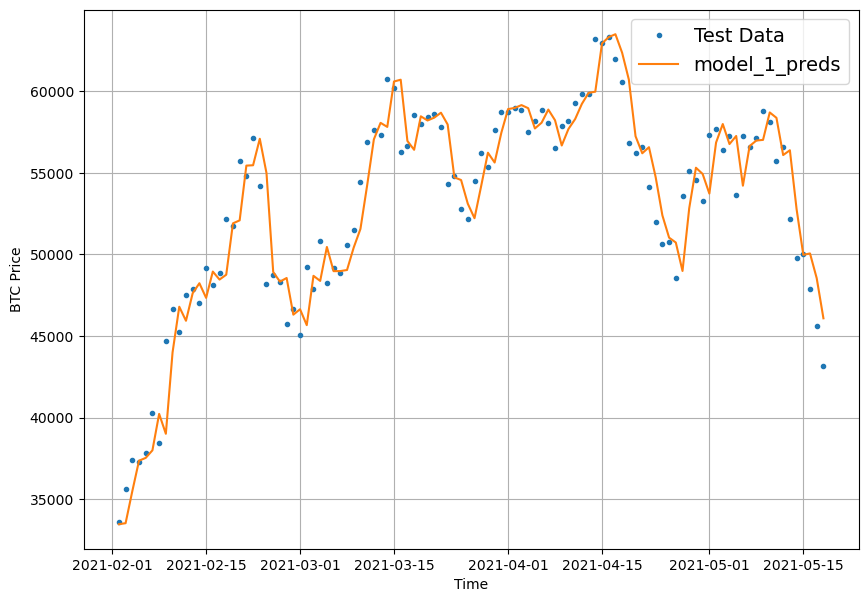

In [52]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset, 
                 format="-",
                 label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [53]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [54]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)


window setp: [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]



(2757, 2757)

In [55]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [56]:

#import absl.logging
#absl.logging.set_verbosity(absl.logging.ERROR)



# Create model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


In [57]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 646.1402


646.1401977539062

In [58]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 908us/step - loss: 613.3603


613.3602905273438

In [59]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [60]:
tf.squeeze(test_labels).shape, model_2_preds.shape

(TensorShape([552]), TensorShape([552]))

In [61]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 613.3602,
 'mse': 1296884.4,
 'rmse': 1138.8083,
 'mape': 2.7484307,
 'mase': 1.0721596}

In [62]:
model_1_results

{'mae': 566.0115,
 'mse': 1161171.0,
 'rmse': 1077.5764,
 'mape': 2.5332437,
 'mase': 0.9943254}

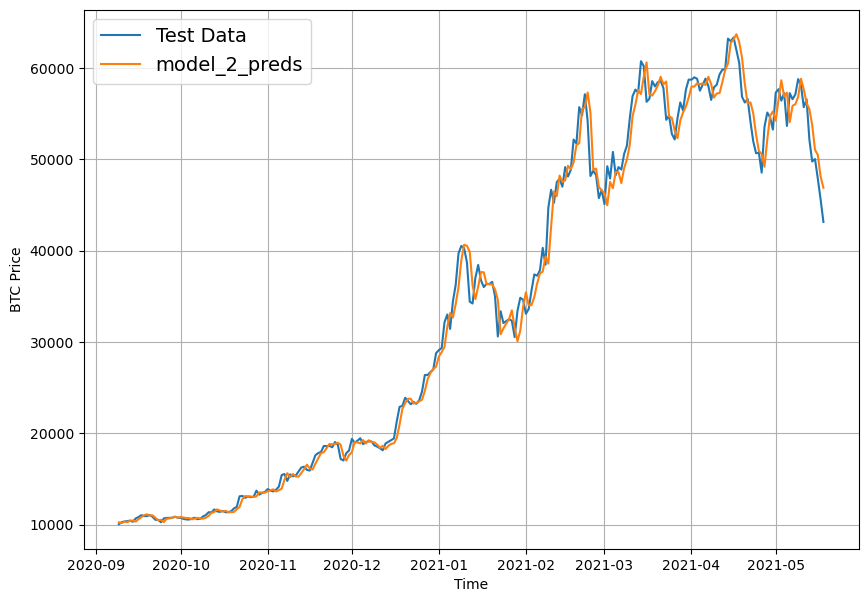

In [63]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

### Model 3: Dense (window = 30, horizon = 7)

In [64]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [65]:
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [66]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

window setp: [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]]



(2751, 2751)

In [67]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [68]:
def build_model_arq1(horizon,name):
    model = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(horizon)
    ], name=name)
    return model
    

In [69]:
# build
model_3 = build_model_arq1(HORIZON,"model_3_dense")

# Compile
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 6s - loss: 3431.9102INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 26ms/step - loss: 1653.4984 - val_loss: 3069.0276
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 609.9102INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 23ms/step - loss: 576.7587 - val_loss: 2834.5195
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 619.7269INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 23ms/step - loss: 449.5183 - val_loss: 2224.5686
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 359.8456INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 396.8746 - val_loss: 1863.2112
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 362.0138 - val_loss: 1982.9976
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 387.8358INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 341.8246 - val_loss: 1713.1548
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 326.2601INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 331.0314 - val_loss: 1635.0294
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 293.1071INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 22ms/step - loss: 315.8266 - val_loss: 1619.0013
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 285.2149INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 310.6460 - val_loss: 1558.3412
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 367.1924INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 34ms/step - loss: 298.2124 - val_loss: 1523.9375
Epoch 11/100
18/18 [==============================] - 0s 3ms/step - loss: 289.7615 - val_loss: 1650.6064
Epoch 12/100
18/18 [==============================] - 0s 3ms/step - loss: 285.9599 - val_loss: 1562.9640
Epoch 13/100
18/18 [==============================] - 0s 3ms/step - loss: 292.2000 - val_loss: 1537.0126
Epoch 14/100
18/18 [==============================] - 0s 3ms/step - loss: 278.5019 - val_loss: 1529.6349
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 251.7038INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 23ms/step - loss: 283.2556 - val_loss: 1486.4161
Epoch 16/100
18/18 [==============================] - 0s 2ms/step - loss: 274.8557 - val_loss: 1493.8181
Epoch 17/100
18/18 [==============================] - 0s 2ms/step - loss: 267.6874 - val_loss: 1486.5623
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 232.2133INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 267.6309 - val_loss: 1459.2443
Epoch 19/100
18/18 [==============================] - 0s 2ms/step - loss: 262.2248 - val_loss: 1592.1243
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 209.6338INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 260.9435 - val_loss: 1440.8274
Epoch 21/100
18/18 [==============================] - 0s 2ms/step - loss: 271.8575 - val_loss: 1539.3234
Epoch 22/100
18/18 [==============================] - 0s 2ms/step - loss: 271.3020 - val_loss: 1461.5463
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 247.1844INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 22ms/step - loss: 267.0500 - val_loss: 1393.4424
Epoch 24/100
18/18 [==============================] - 0s 2ms/step - loss: 256.1039 - val_loss: 1403.8756
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 293.0108INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 22ms/step - loss: 254.3570 - val_loss: 1373.5063
Epoch 26/100
18/18 [==============================] - 0s 2ms/step - loss: 254.2866 - val_loss: 1462.7928
Epoch 27/100
18/18 [==============================] - 0s 2ms/step - loss: 258.3709 - val_loss: 1511.1584
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 217.9841INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 23ms/step - loss: 249.9165 - val_loss: 1370.8119
Epoch 29/100
18/18 [==============================] - 0s 3ms/step - loss: 249.6588 - val_loss: 1428.8308
Epoch 30/100
18/18 [==============================] - 0s 3ms/step - loss: 256.4401 - val_loss: 1478.5995
Epoch 31/100
18/18 [==============================] - 0s 3ms/step - loss: 253.8657 - val_loss: 1498.1144
Epoch 32/100
18/18 [==============================] - 0s 2ms/step - loss: 251.8652 - val_loss: 1393.8113
Epoch 33/100
18/18 [==============================] - 0s 3ms/step - loss: 246.0635 - val_loss: 1407.1223
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 222.7376INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 22ms/step - loss: 247.0855 - val_loss: 1325.9688
Epoch 35/100
18/18 [==============================] - 0s 2ms/step - loss: 245.8557 - val_loss: 1348.4222
Epoch 36/100
18/18 [==============================] - 0s 2ms/step - loss: 243.8633 - val_loss: 1377.3027
Epoch 37/100
18/18 [==============================] - 0s 2ms/step - loss: 244.1462 - val_loss: 1645.2499
Epoch 38/100
18/18 [==============================] - 0s 2ms/step - loss: 252.7785 - val_loss: 1359.3110
Epoch 39/100
18/18 [==============================] - 0s 2ms/step - loss: 244.1245 - val_loss: 1535.0953
Epoch 40/100
18/18 [==============================] - 0s 2ms/step - loss: 245.2219 - val_loss: 1331.0316
Epoch 41/100
18/18 [==============================] - 0s 2ms/step - loss: 253.4348 - val_loss: 1510.9912
Epoch 42/100
18/18 [==============================] - 0s 2ms/step - loss: 246.2274 - val_loss: 1332.8833
Epoch 43/100
18/18 [==============================] - 0s 2ms/step -

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 23ms/step - loss: 241.2637 - val_loss: 1292.5679
Epoch 49/100
18/18 [==============================] - 0s 2ms/step - loss: 243.5226 - val_loss: 1387.1688
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 289.6628INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 22ms/step - loss: 238.7170 - val_loss: 1292.4471
Epoch 51/100
18/18 [==============================] - 0s 2ms/step - loss: 240.5607 - val_loss: 1342.7559
Epoch 52/100
18/18 [==============================] - 0s 2ms/step - loss: 235.5636 - val_loss: 1293.1332
Epoch 53/100
18/18 [==============================] - 0s 2ms/step - loss: 233.7399 - val_loss: 1333.7795
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 244.4312INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 24ms/step - loss: 235.7888 - val_loss: 1288.0726
Epoch 55/100
18/18 [==============================] - 0s 3ms/step - loss: 239.4341 - val_loss: 1305.5425
Epoch 56/100
 1/18 [>.............................] - ETA: 0s - loss: 290.4383INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 243.5119 - val_loss: 1276.2594
Epoch 57/100
18/18 [==============================] - 0s 2ms/step - loss: 243.8814 - val_loss: 1301.2068
Epoch 58/100
 1/18 [>.............................] - ETA: 0s - loss: 251.7987INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 24ms/step - loss: 236.3130 - val_loss: 1272.2321
Epoch 59/100
18/18 [==============================] - 0s 3ms/step - loss: 234.4490 - val_loss: 1401.9835
Epoch 60/100
18/18 [==============================] - 0s 3ms/step - loss: 239.5078 - val_loss: 1474.8092
Epoch 61/100
18/18 [==============================] - 0s 3ms/step - loss: 242.9432 - val_loss: 1387.4067
Epoch 62/100
18/18 [==============================] - 0s 2ms/step - loss: 236.7762 - val_loss: 1425.7247
Epoch 63/100
18/18 [==============================] - 0s 3ms/step - loss: 234.8338 - val_loss: 1300.6606
Epoch 64/100
18/18 [==============================] - 0s 3ms/step - loss: 234.4866 - val_loss: 1288.0543
Epoch 65/100
18/18 [==============================] - 0s 3ms/step - loss: 240.9900 - val_loss: 1308.7202
Epoch 66/100
18/18 [==============================] - 0s 3ms/step - loss: 241.4301 - val_loss: 1304.9050
Epoch 67/100
18/18 [==============================] - 0s 3ms/step -

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 28ms/step - loss: 236.8023 - val_loss: 1259.1334
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 232.9462 - val_loss: 1296.3716
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 234.3192 - val_loss: 1326.7599
Epoch 72/100
18/18 [==============================] - 0s 3ms/step - loss: 234.7305 - val_loss: 1352.2659
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 234.0283 - val_loss: 1302.8555
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 238.1284 - val_loss: 1295.1715
Epoch 75/100
18/18 [==============================] - 0s 3ms/step - loss: 230.2053 - val_loss: 1263.5798
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 248.0222INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 25ms/step - loss: 229.9142 - val_loss: 1244.8798
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 237.1297 - val_loss: 1269.7764
Epoch 78/100
 1/18 [>.............................] - ETA: 0s - loss: 322.5478INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 42ms/step - loss: 232.1348 - val_loss: 1241.3339
Epoch 79/100
18/18 [==============================] - 0s 3ms/step - loss: 230.8459 - val_loss: 1447.2372
Epoch 80/100
18/18 [==============================] - 0s 2ms/step - loss: 236.9602 - val_loss: 1311.4834
Epoch 81/100
18/18 [==============================] - 0s 2ms/step - loss: 229.4297 - val_loss: 1525.9945
Epoch 82/100
18/18 [==============================] - 0s 2ms/step - loss: 240.6487 - val_loss: 1269.8085
Epoch 83/100
18/18 [==============================] - 0s 3ms/step - loss: 241.0538 - val_loss: 1374.6108
Epoch 84/100
18/18 [==============================] - 0s 2ms/step - loss: 231.1026 - val_loss: 1251.9707
Epoch 85/100
18/18 [==============================] - 0s 3ms/step - loss: 226.6443 - val_loss: 1448.9373
Epoch 86/100
18/18 [==============================] - 0s 3ms/step - loss: 230.4057 - val_loss: 1254.3011
Epoch 87/100
18/18 [==============================] - 0s 2ms/step -

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 0s 23ms/step - loss: 228.2523 - val_loss: 1235.0265
Epoch 90/100
18/18 [==============================] - 0s 2ms/step - loss: 226.4596 - val_loss: 1342.6030
Epoch 91/100
18/18 [==============================] - 0s 3ms/step - loss: 233.2485 - val_loss: 1312.2590
Epoch 92/100
18/18 [==============================] - 0s 2ms/step - loss: 229.9120 - val_loss: 1263.1202
Epoch 93/100
18/18 [==============================] - 0s 2ms/step - loss: 231.6557 - val_loss: 1436.9689
Epoch 94/100
18/18 [==============================] - 0s 2ms/step - loss: 231.5766 - val_loss: 1308.1549
Epoch 95/100
18/18 [==============================] - 0s 2ms/step - loss: 252.3358 - val_loss: 1311.6738
Epoch 96/100
18/18 [==============================] - 0s 2ms/step - loss: 228.0947 - val_loss: 1298.2502
Epoch 97/100
18/18 [==============================] - 0s 3ms/step - loss: 227.0003 - val_loss: 1367.8934
Epoch 98/100
18/18 [==============================] - 0s 3ms/step -

In [70]:
# Evaluate the model on the test data

# va a ser mayor xq aotra el horizonte ya no es 1, sino que mucho m[as
# predceinos mucho m[as alla en el futuro]

model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 829us/step - loss: 1391.5576


1391.5576171875

In [71]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 898us/step - loss: 1235.0265


1235.0264892578125

In [72]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 784us/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9170.135, 9298.357, 9344.754, 9346.303, 9150.092, 9444.054,
        9407.968],
       [9055.54 , 9185.88 , 9205.531, 9303.115, 9145.385, 9466.011,
        9060.053],
       [9020.287, 9031.73 , 9037.178, 9026.397, 9089.886, 9158.36 ,
        8753.135],
       [9073.258, 9040.096, 8997.73 , 9092.525, 9202.918, 9205.037,
        8916.067],
       [8882.907, 9022.758, 8919.515, 9212.027, 9003.519, 9198.848,
        9086.915]], dtype=float32)>

In [73]:
model_2_results

{'mae': 613.3602,
 'mse': 1296884.4,
 'rmse': 1138.8083,
 'mape': 2.7484307,
 'mase': 1.0721596}

In [74]:
model_3_preds.shape, model_2_preds.shape, model_1_preds.shape

(TensorShape([551, 7]), TensorShape([552]), TensorShape([556]))

In [75]:
# Evaluate model_3 results (these are going multi-dimensional because we're trying to predict more than one timestep at a time)
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 515.5939  ,  451.8178  ,  329.8234  ,  448.7814  ,  492.2934  ,
         470.5828  ,  511.55246 ,  547.0697  ,  488.033   ,  565.14734 ,
         753.88947 ,  792.54004 ,  791.7584  ,  871.807   ,  651.2837  ,
         307.1613  ,  192.28844 ,  242.60408 ,  306.98926 ,  322.0752  ,
         194.49086 ,  132.80797 ,  307.02945 ,  302.6414  ,  185.22803 ,
         118.82945 ,   84.65116 ,  143.4615  ,  154.75545 ,  192.23389 ,
         311.99945 ,  276.84793 ,  322.00027 ,  370.06592 ,  257.28934 ,
         322.83105 ,  334.0337  ,  253.69699 ,  170.38547 ,  201.00008 ,
         436.05768 ,  157.76115 ,   79.93464 ,   78.82513 ,   68.412315,
         105.26381 ,  111.338585,   95.6905  ,   83.55434 ,  146.07324 ,
         136.9257  ,  146.66365 ,  134.99728 ,  185.7152  ,  202.99623 ,
         321.24136 ,  478.43805 ,  576.5318  ,  417.50607 ,  572.4711  ,
         406.89438 ,  184.26389 ,  259.8801  ,  349.80093 ,  399.97803 ,
         449.958   ,  487.3819  ,  509.04395

In [76]:
model_3_preds.shape # el 7 es xq el horizonte es 7

TensorShape([551, 7])

### Make our evaluation function work for larger horizons

In [77]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 823us/step - loss: 1235.0265


1235.0264892578125

In [78]:
tf.reduce_mean(model_3_results["mae"]).numpy()

1235.0265

In [79]:
model_2_results["mae"].ndim

0

In [80]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [81]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1235.0265,
 'mse': 5287946.0,
 'rmse': 1420.0663,
 'mape': 5.5567665,
 'mase': 2.1976604}

In [82]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9170.135, 9298.357, 9344.754, 9346.303, 9150.092, 9444.054,
        9407.968],
       [9055.54 , 9185.88 , 9205.531, 9303.115, 9145.385, 9466.011,
        9060.053],
       [9020.287, 9031.73 , 9037.178, 9026.397, 9089.886, 9158.36 ,
        8753.135],
       [9073.258, 9040.096, 8997.73 , 9092.525, 9202.918, 9205.037,
        8916.067],
       [8882.907, 9022.758, 8919.515, 9212.027, 9003.519, 9198.848,
        9086.915]], dtype=float32)>

In [83]:
test_labels[:]

array([[ 8794.35864452,  8798.04205463,  9081.18687849, ...,
         8760.89271814,  8749.52059102,  8656.97092235],
       [ 8798.04205463,  9081.18687849,  8711.53433917, ...,
         8749.52059102,  8656.97092235,  8500.64355816],
       [ 9081.18687849,  8711.53433917,  8760.89271814, ...,
         8656.97092235,  8500.64355816,  8469.2608989 ],
       ...,
       [58102.19142623, 55715.54665129, 56573.5554719 , ...,
        49764.1320816 , 50032.69313676, 47885.62525472],
       [55715.54665129, 56573.5554719 , 52147.82118698, ...,
        50032.69313676, 47885.62525472, 45604.61575361],
       [56573.5554719 , 52147.82118698, 49764.1320816 , ...,
        47885.62525472, 45604.61575361, 43144.47129086]])

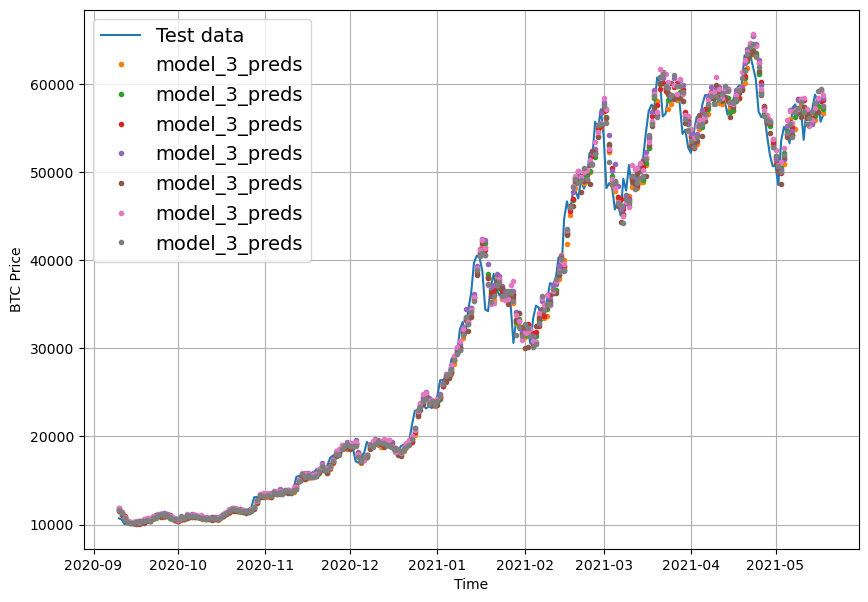

In [84]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

In [85]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9170.135, 9298.357, 9344.754, 9346.303, 9150.092, 9444.054,
       9407.968], dtype=float32)>

In [86]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9308.81>

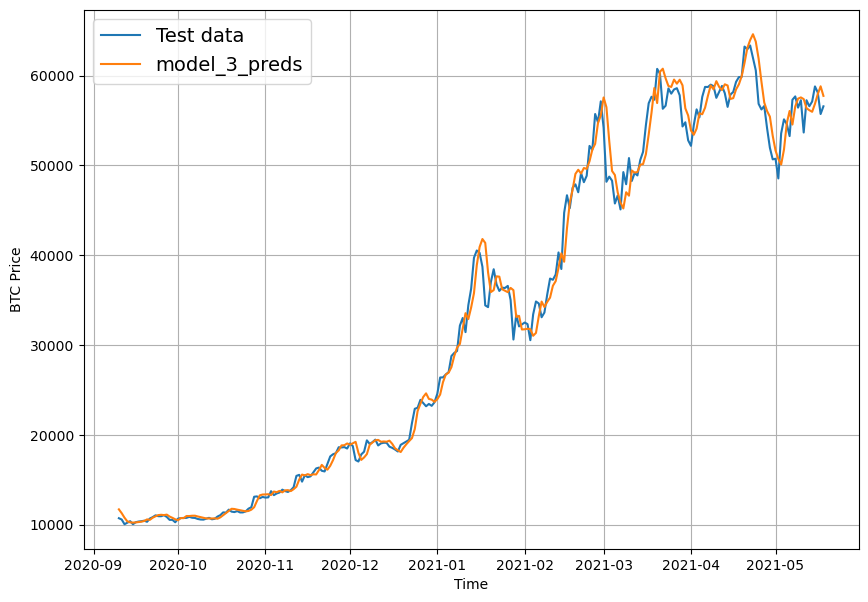

In [87]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 format="-",
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 start=offset,
                 format="-", 
                 label="model_3_preds")

## Which of our models is performing the best so far? 

So we've trained a few models, now let's compare them and see how they've gone... 

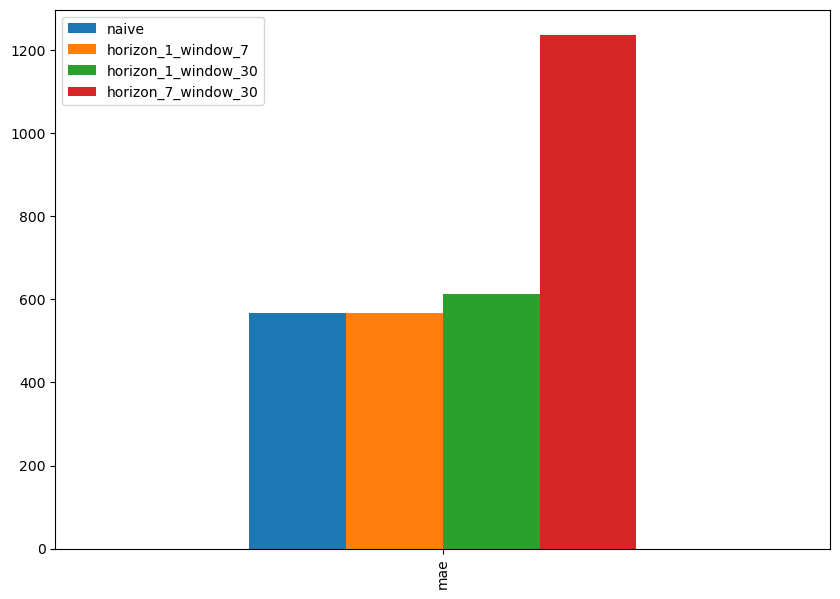

In [88]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

recuerdo que mientras menor sea el error, mejor

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls by Vegard Flovik](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424).

### Model 4: Conv1D

In [89]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [90]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

window setp: [[0 1 2 3 4 5 6 7]]



(2780, 2780)

In [91]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

En el contexto de un problema de series temporales con un horizonte (horizon) de 1 y un tamaño de ventana (window_size) de 7, la forma del tensor de entrada (input_shape) sería crucial para determinar el tamaño de input_dim. La forma general del tensor sería (batch_size, window_size, input_dim).

Dado que window_size es 7, el modelo consideraría secuencias de 7 pasos temporales como entrada en cada lote. Sin embargo, el horizonte de predicción (horizon) es 1, lo que significa que el modelo está diseñado para predecir el siguiente paso temporal en cada secuencia.

Por lo tanto, el tamaño de input_dim debe ser el número de características o variables en cada paso temporal. Si tus secuencias tienen una única característica en cada paso de tiempo (por ejemplo, univariadas), entonces input_dim sería 1. Si tienes múltiples características en cada paso de tiempo (por ejemplo, series temporales multivariadas), entonces input_dim sería el número total de características.

Entonces, en resumen, para un problema de series temporales con un horizonte de 1 y una ventana de 7, y si tus datos tienen una sola característica en cada paso de tiempo, input_dim debería ser 1. Si tienes múltiples características en cada paso de tiempo, input_dim sería el número total de características.

In [92]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )



(7,)

In [93]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [94]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`


# queremos que el modelo prediga un día con una 1 semana de datos, por eso input_dim=1?????


In [95]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDIW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = ...?
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [96]:

#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

# nota expand dims

aux = tf.constant([1,2,3])

print(aux.shape)


aux2 = tf.expand_dims(aux,axis=1)


print(aux2.shape)


print(aux2)


(3,)
(3, 1)
tf.Tensor(
[[1]
 [2]
 [3]], shape=(3, 1), dtype=int32)


In [97]:
def build_model_4(x,horizon):
    model = tf.keras.Sequential([
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
        tf.keras.layers.Dense(horizon)
    ],name="model_4_conv1D")
    return model
    
    
model_4 = build_model_4(x,1)
    

In [98]:
# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 7s - loss: 3891.8923INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 2283.7896 - val_loss: 3931.7185
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 570.9983INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 330.7987 - val_loss: 1154.6873
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 250.8300INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 30ms/step - loss: 209.6959 - val_loss: 982.3718
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 180.3158 - val_loss: 1010.0858
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 174.2902 - val_loss: 1089.0909
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 175.2451 - val_loss: 985.7627
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 140.0597INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 30ms/step - loss: 171.2858 - val_loss: 943.3794
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 167.6008INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 168.0383 - val_loss: 931.6805
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 206.0264INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 163.9204 - val_loss: 911.4424
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 213.6268INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 47ms/step - loss: 161.0677 - val_loss: 893.5875
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 145.5269INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 158.4182 - val_loss: 885.3839
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 155.7542INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 156.6706 - val_loss: 881.0732
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 154.1189INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 155.3320 - val_loss: 853.2214
Epoch 14/100
18/18 [==============================] - 0s 3ms/step - loss: 151.1977 - val_loss: 885.8892
Epoch 15/100
18/18 [==============================] - 0s 2ms/step - loss: 148.5235 - val_loss: 866.8038
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 128.3264INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 146.5276 - val_loss: 832.6470
Epoch 17/100
18/18 [==============================] - 0s 2ms/step - loss: 146.4449 - val_loss: 841.3103
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 181.9196INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 30ms/step - loss: 146.7913 - val_loss: 778.0145
Epoch 19/100
18/18 [==============================] - 0s 2ms/step - loss: 142.1359 - val_loss: 795.2489
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 170.9119INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 138.1755 - val_loss: 769.6957
Epoch 21/100
18/18 [==============================] - 0s 2ms/step - loss: 136.3802 - val_loss: 771.2296
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 205.0807INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 136.7040 - val_loss: 733.3718
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 109.6872INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 135.4783 - val_loss: 724.5120
Epoch 24/100
18/18 [==============================] - 0s 2ms/step - loss: 134.2826 - val_loss: 737.7440
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 169.3240INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 132.2375 - val_loss: 707.9183
Epoch 26/100
18/18 [==============================] - 0s 2ms/step - loss: 130.9284 - val_loss: 781.5244
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 134.2850INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 139.7311 - val_loss: 690.2822
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 136.7884INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 46ms/step - loss: 125.3616 - val_loss: 682.5254
Epoch 29/100
18/18 [==============================] - 0s 3ms/step - loss: 124.5360 - val_loss: 714.9675
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 98.4564INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 126.4846 - val_loss: 674.8530
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 118.4540INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 124.3782 - val_loss: 665.9031
Epoch 32/100
18/18 [==============================] - 0s 2ms/step - loss: 122.9632 - val_loss: 679.1438
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 118.6984INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 121.7577 - val_loss: 661.7359
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 110.0209INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 126.0343 - val_loss: 646.9451
Epoch 35/100
18/18 [==============================] - 0s 2ms/step - loss: 120.7215 - val_loss: 658.0663
Epoch 36/100
18/18 [==============================] - 0s 3ms/step - loss: 123.5155 - val_loss: 767.1498
Epoch 37/100
18/18 [==============================] - 0s 3ms/step - loss: 134.1144 - val_loss: 798.7783
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 129.6852INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 129.0546 - val_loss: 633.9066
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 74.4464INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 118.4612 - val_loss: 631.3721
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 147.2602INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 117.6346 - val_loss: 626.4979
Epoch 41/100
18/18 [==============================] - 0s 2ms/step - loss: 122.0840 - val_loss: 638.0517
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 123.7701INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 117.4210 - val_loss: 621.4980
Epoch 43/100
18/18 [==============================] - 0s 2ms/step - loss: 116.2218 - val_loss: 624.7925
Epoch 44/100
18/18 [==============================] - 0s 2ms/step - loss: 118.4450 - val_loss: 625.4841
Epoch 45/100
18/18 [==============================] - 0s 2ms/step - loss: 119.0615 - val_loss: 638.9921
Epoch 46/100
18/18 [==============================] - 0s 2ms/step - loss: 114.5537 - val_loss: 631.8842
Epoch 47/100
18/18 [==============================] - 0s 2ms/step - loss: 118.2586 - val_loss: 631.1299
Epoch 48/100
18/18 [==============================] - 0s 2ms/step - loss: 116.4216 - val_loss: 621.7471
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 106.8904INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 45ms/step - loss: 115.5018 - val_loss: 614.6856
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 111.1978INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 120.7422 - val_loss: 613.9289
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 121.0109INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 119.7725 - val_loss: 602.5706
Epoch 52/100
18/18 [==============================] - 0s 3ms/step - loss: 112.7199 - val_loss: 603.5958
Epoch 53/100
18/18 [==============================] - 0s 2ms/step - loss: 113.3771 - val_loss: 604.5103
Epoch 54/100
18/18 [==============================] - 0s 2ms/step - loss: 115.3602 - val_loss: 700.1902
Epoch 55/100
18/18 [==============================] - 0s 2ms/step - loss: 119.7834 - val_loss: 689.4999
Epoch 56/100
 1/18 [>.............................] - ETA: 0s - loss: 120.0209INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 114.0731 - val_loss: 594.9534
Epoch 57/100
18/18 [==============================] - 0s 3ms/step - loss: 112.0915 - val_loss: 634.4533
Epoch 58/100
18/18 [==============================] - 0s 3ms/step - loss: 114.8611 - val_loss: 597.5710
Epoch 59/100
18/18 [==============================] - 0s 3ms/step - loss: 114.1703 - val_loss: 685.9239
Epoch 60/100
18/18 [==============================] - 0s 2ms/step - loss: 127.1191 - val_loss: 602.9086
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 110.4346INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 34ms/step - loss: 111.7400 - val_loss: 591.4561
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 116.7200INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 34ms/step - loss: 110.9500 - val_loss: 591.0098
Epoch 63/100
18/18 [==============================] - 0s 3ms/step - loss: 110.7691 - val_loss: 726.5233
Epoch 64/100
18/18 [==============================] - 0s 3ms/step - loss: 123.2217 - val_loss: 678.2792
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 140.3882INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 113.6477 - val_loss: 588.1110
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 147.2439INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 112.2855 - val_loss: 587.1098
Epoch 67/100
18/18 [==============================] - 0s 2ms/step - loss: 115.1222 - val_loss: 587.2078
Epoch 68/100
18/18 [==============================] - 0s 2ms/step - loss: 112.3504 - val_loss: 627.6823
Epoch 69/100
 1/18 [>.............................] - ETA: 0s - loss: 117.4937INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 111.5770 - val_loss: 584.1190
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 132.5787INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 31ms/step - loss: 111.2054 - val_loss: 582.2051
Epoch 71/100
 1/18 [>.............................] - ETA: 0s - loss: 118.3395INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 30ms/step - loss: 111.0300 - val_loss: 580.1134
Epoch 72/100
18/18 [==============================] - 0s 2ms/step - loss: 110.2780 - val_loss: 651.8300
Epoch 73/100
 1/18 [>.............................] - ETA: 0s - loss: 158.3471INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 47ms/step - loss: 111.2197 - val_loss: 579.5450
Epoch 74/100
18/18 [==============================] - 0s 2ms/step - loss: 109.6686 - val_loss: 628.3370
Epoch 75/100
18/18 [==============================] - 0s 2ms/step - loss: 116.0380 - val_loss: 699.0281
Epoch 76/100
18/18 [==============================] - 0s 2ms/step - loss: 113.2114 - val_loss: 598.2699
Epoch 77/100
18/18 [==============================] - 0s 2ms/step - loss: 112.2431 - val_loss: 585.9550
Epoch 78/100
18/18 [==============================] - 0s 2ms/step - loss: 111.6623 - val_loss: 586.0947
Epoch 79/100
18/18 [==============================] - 0s 2ms/step - loss: 108.5496 - val_loss: 599.2856
Epoch 80/100
18/18 [==============================] - 0s 2ms/step - loss: 108.2951 - val_loss: 594.2186
Epoch 81/100
18/18 [==============================] - 0s 2ms/step - loss: 109.5779 - val_loss: 622.8368
Epoch 82/100
18/18 [==============================] - 0s 2ms/step - loss: 10

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 34ms/step - loss: 116.9996 - val_loss: 577.9684
Epoch 85/100
18/18 [==============================] - 0s 2ms/step - loss: 109.3368 - val_loss: 603.5765
Epoch 86/100
18/18 [==============================] - 0s 2ms/step - loss: 108.2416 - val_loss: 623.8144
Epoch 87/100
18/18 [==============================] - 0s 2ms/step - loss: 110.0484 - val_loss: 625.8328
Epoch 88/100
18/18 [==============================] - 0s 2ms/step - loss: 114.1335 - val_loss: 582.6234
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 104.4681INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 110.6848 - val_loss: 576.0866
Epoch 90/100
18/18 [==============================] - 0s 2ms/step - loss: 115.0185 - val_loss: 584.9069
Epoch 91/100
18/18 [==============================] - 0s 2ms/step - loss: 108.2764 - val_loss: 650.8641
Epoch 92/100
18/18 [==============================] - 0s 2ms/step - loss: 114.1645 - val_loss: 646.3487
Epoch 93/100
18/18 [==============================] - 0s 2ms/step - loss: 115.3436 - val_loss: 746.1632
Epoch 94/100
18/18 [==============================] - 0s 2ms/step - loss: 111.7014 - val_loss: 597.2642
Epoch 95/100
 1/18 [>.............................] - ETA: 0s - loss: 127.6401INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 32ms/step - loss: 109.2901 - val_loss: 572.7911
Epoch 96/100
 1/18 [>.............................] - ETA: 0s - loss: 88.0136INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 33ms/step - loss: 108.0643 - val_loss: 570.8579
Epoch 97/100
18/18 [==============================] - 0s 2ms/step - loss: 108.8973 - val_loss: 582.9346
Epoch 98/100
18/18 [==============================] - 0s 2ms/step - loss: 108.5245 - val_loss: 598.9548
Epoch 99/100
18/18 [==============================] - 0s 2ms/step - loss: 113.2387 - val_loss: 719.9036
Epoch 100/100
18/18 [==============================] - 0s 2ms/step - loss: 120.7225 - val_loss: 661.0927


In [99]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [100]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


vemos que el tamaño de la salida de los modelos es diferente

In [101]:
# Evaluate model... 
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 838us/step - loss: 661.0927


661.0927124023438

In [102]:
# Load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 570.8579


570.85791015625

In [103]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8909.759 , 8816.046 , 9021.3955, 8828.718 , 8774.765 , 8742.651 ,
       8697.069 , 8570.549 , 8477.132 , 8537.287 ], dtype=float32)>

In [104]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.8579,
 'mse': 1190877.0,
 'rmse': 1091.2731,
 'mape': 2.558025,
 'mase': 1.0028392}

### Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously.

In [105]:



def build_model_5(window_size):
    # Let's build an LSTM model with the Functional API
    inputs = layers.Input(shape=(window_size))
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    # x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(128, activation="relu")(x)
    # x = layers.Dense(32, activation="relu")(x)
    output = layers.Dense(HORIZON)(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")
    return model


model_5 = build_model_5(WINDOW_SIZE)
    
    
# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 2704.2957 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 97ms/step - loss: 2687.3167 - val_loss: 10862.7705
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 1680.5273INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 106ms/step - loss: 785.5025 - val_loss: 2221.6619
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 265.7464INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 87ms/step - loss: 256.1628 - val_loss: 1203.9086
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 250.8281INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 82ms/step - loss: 187.5424 - val_loss: 1151.6090
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 222.6476INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 182.9061 - val_loss: 1011.0378
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 193.9007INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 85ms/step - loss: 180.5910 - val_loss: 995.8461
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 130.4933INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 93ms/step - loss: 169.1448 - val_loss: 853.9738
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 170.1753 - val_loss: 1013.2180
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 174.1630 - val_loss: 1024.8341
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 172.0081 - val_loss: 966.2433
Epoch 11/100
18/18 [==============================] - 0s 5ms/step - loss: 171.5365 - val_loss: 963.7293
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 172.7185 - val_loss: 1039.0420
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 169.2355 - val_loss: 929.0606
Epoch 14/100
18/18 [==============================] - 0s 5ms/step - loss: 164.2216 - val_loss: 969.7667
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 163.6285 - val_loss: 920.3187
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 1

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 83ms/step - loss: 159.3950 - val_loss: 850.7180
Epoch 21/100
16/18 [=========================>....] - ETA: 0s - loss: 148.1685INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 85ms/step - loss: 152.7803 - val_loss: 834.5220
Epoch 22/100
18/18 [==============================] - 0s 4ms/step - loss: 151.5464 - val_loss: 897.3722
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 158.5203INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 105ms/step - loss: 147.9469 - val_loss: 825.2662
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 199.0196INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 81ms/step - loss: 147.6112 - val_loss: 820.1278
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 119.7439INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 81ms/step - loss: 144.8300 - val_loss: 806.3072
Epoch 26/100
18/18 [==============================] - 0s 4ms/step - loss: 142.2480 - val_loss: 812.2241
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 124.6708INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 141.1131 - val_loss: 779.4247
Epoch 28/100
18/18 [==============================] - 0s 4ms/step - loss: 140.5679 - val_loss: 794.0279
Epoch 29/100
18/18 [==============================] - 0s 4ms/step - loss: 141.4250 - val_loss: 796.7045
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 158.4066INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 82ms/step - loss: 137.0477 - val_loss: 751.9308
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 136.4586 - val_loss: 822.9741
Epoch 32/100
18/18 [==============================] - 0s 4ms/step - loss: 134.8577 - val_loss: 809.8146
Epoch 33/100
18/18 [==============================] - 0s 4ms/step - loss: 137.4292 - val_loss: 808.0178
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 135.6024 - val_loss: 761.4384
Epoch 35/100
17/18 [===========================>..] - ETA: 0s - loss: 131.8135INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 90ms/step - loss: 132.2274 - val_loss: 747.7676
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 128.7415INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 82ms/step - loss: 129.7832 - val_loss: 711.5336
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 131.0186 - val_loss: 723.5572
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 128.2590 - val_loss: 724.3988
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 127.7103 - val_loss: 754.7982
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 136.8162INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 84ms/step - loss: 126.4529 - val_loss: 690.8492
Epoch 41/100
17/18 [===========================>..] - ETA: 0s - loss: 125.8492INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 110ms/step - loss: 125.3564 - val_loss: 689.7501
Epoch 42/100
18/18 [==============================] - ETA: 0s - loss: 125.8677INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 83ms/step - loss: 125.8677 - val_loss: 682.7763
Epoch 43/100
 1/18 [>.............................] - ETA: 0s - loss: 154.8434INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 84ms/step - loss: 127.2152 - val_loss: 677.2121
Epoch 44/100
18/18 [==============================] - 0s 4ms/step - loss: 126.9838 - val_loss: 743.2447
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 123.2289INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 130.3124 - val_loss: 669.2278
Epoch 46/100
18/18 [==============================] - 0s 4ms/step - loss: 134.9201 - val_loss: 816.6903
Epoch 47/100
18/18 [==============================] - ETA: 0s - loss: 129.8327INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 90ms/step - loss: 129.8327 - val_loss: 661.0366
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 121.4549 - val_loss: 669.3409
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 123.5011 - val_loss: 687.5644
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 122.1725 - val_loss: 722.4899
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 121.4341 - val_loss: 680.3971
Epoch 52/100
17/18 [===========================>..] - ETA: 0s - loss: 121.5764INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 85ms/step - loss: 121.5774 - val_loss: 649.8007
Epoch 53/100
 1/18 [>.............................] - ETA: 0s - loss: 108.1359INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 87ms/step - loss: 119.4027 - val_loss: 646.7006
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 120.5922 - val_loss: 662.7505
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 125.6017 - val_loss: 684.8710
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 125.7164 - val_loss: 682.5051
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 123.5501 - val_loss: 729.9099
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 124.8151 - val_loss: 667.4357
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 121.7538 - val_loss: 684.2065
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 147.9856INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 86ms/step - loss: 119.0305 - val_loss: 633.1227
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 116.9975 - val_loss: 645.2996
Epoch 62/100
18/18 [==============================] - 0s 4ms/step - loss: 119.8965 - val_loss: 639.5131
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 117.6124 - val_loss: 633.4210
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 117.2138 - val_loss: 635.4897
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 97.5163INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 105ms/step - loss: 118.1621 - val_loss: 628.4283
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 103.0967INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 81ms/step - loss: 115.0640 - val_loss: 620.1633
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 115.3090 - val_loss: 622.3185
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 118.7491 - val_loss: 620.3574
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 116.7488 - val_loss: 623.4669
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 114.8129 - val_loss: 624.1683
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 115.6991 - val_loss: 627.8304
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 91.2800INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 84ms/step - loss: 114.6251 - val_loss: 613.7091
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 114.9933 - val_loss: 624.0754
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 116.7171 - val_loss: 663.6662
Epoch 75/100
 1/18 [>.............................] - ETA: 0s - loss: 123.8678INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 98ms/step - loss: 119.9069 - val_loss: 608.8289
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 114.0660INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 87ms/step - loss: 115.7883 - val_loss: 607.6692
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 97.8709INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 82ms/step - loss: 113.3716 - val_loss: 607.5278
Epoch 78/100
18/18 [==============================] - ETA: 0s - loss: 113.3280INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 84ms/step - loss: 113.3280 - val_loss: 606.2953
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 114.1311 - val_loss: 637.7729
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 112.8932 - val_loss: 611.6332
Epoch 81/100
18/18 [==============================] - 0s 4ms/step - loss: 113.2309 - val_loss: 647.3961
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 122.3580INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 82ms/step - loss: 116.7516 - val_loss: 601.8965
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 119.1339 - val_loss: 619.4420
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 114.8098 - val_loss: 617.2571
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 117.5299 - val_loss: 661.9126
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 117.6320 - val_loss: 617.7219
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 113.1443 - val_loss: 610.7121
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 117.1073 - val_loss: 602.3317
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 118.7606 - val_loss: 630.7699
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 115.5781 - val_loss: 612.2402
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 113.3221 - val_loss: 597.0565
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 112.3667 - val_loss: 613.4222
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 117.2015 - val_loss: 713.8068
Epoch 95/100
18/18 [==============================] - 0s 4ms/step - loss: 118.9502 - val_loss: 616.2877
Epoch 96/100
18/18 [==============================] - ETA: 0s - loss: 115.5221INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 83ms/step - loss: 115.5221 - val_loss: 591.3125
Epoch 97/100
18/18 [==============================] - 0s 4ms/step - loss: 111.0692 - val_loss: 634.1332
Epoch 98/100
18/18 [==============================] - 0s 4ms/step - loss: 114.4194 - val_loss: 622.4133
Epoch 99/100
18/18 [==============================] - 0s 4ms/step - loss: 114.6218 - val_loss: 596.9889
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6823 - val_loss: 607.1445


In [106]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 591.3126


591.3125610351562

In [107]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8954.012, 8801.288, 8973.948, 8808.238, 8758.325], dtype=float32)>

In [108]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 591.3126,
 'mse': 1247700.5,
 'rmse': 1117.0051,
 'mape': 2.6504292,
 'mase': 1.0387725}

> 🔑 **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [109]:
# Let's make a multivariate time series 
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [110]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [111]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [112]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [113]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


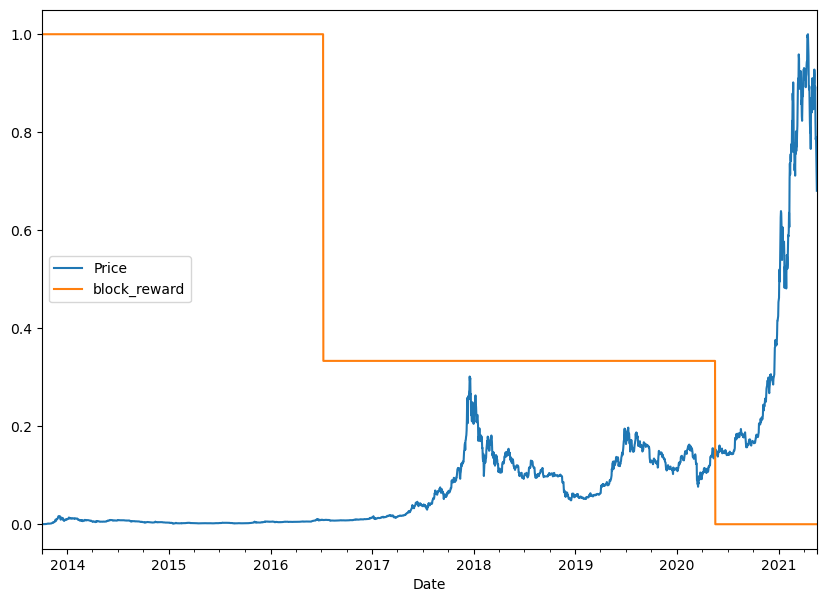

In [114]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

In [115]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [116]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


para los valores price+1 a price+7 el horizonte es price

In [117]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [118]:


# vamos a quitar lo que no tiene valores (los NaN)



# price será la etiqueta


# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [119]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [120]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (multivariate time series)

In [121]:


def build_model_6(horizon,name):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(horizon)
    ],name=name)
    return model
    
    
model_6 = build_model_6(HORIZON,"model_6_dense_multivariate")    


# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 6s - loss: 3672.2095INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 26ms/step - loss: 2266.6616 - val_loss: 4552.6665
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 809.7284INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 391.8245 - val_loss: 1188.5660
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 165.4968INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 200.4246 - val_loss: 1023.8853
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 174.3588INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 182.3797 - val_loss: 1007.0473
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 194.5813INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 178.2206 - val_loss: 1003.4221
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 176.3365INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 171.7022 - val_loss: 944.1721
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 183.7018INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 165.9474 - val_loss: 916.2430
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 147.9183INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 164.5762 - val_loss: 910.6255
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 157.2706INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 161.0916 - val_loss: 904.0894
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 157.5301 - val_loss: 945.9260
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 136.1946INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 158.4367 - val_loss: 900.5046
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 113.5636INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 154.8021 - val_loss: 832.0657
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 152.3982INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 151.4698 - val_loss: 816.8237
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 90.6212INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 149.8813 - val_loss: 808.0975
Epoch 15/100
18/18 [==============================] - 0s 2ms/step - loss: 145.7568 - val_loss: 813.9427
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 141.6033INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 145.7537 - val_loss: 786.9871
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 143.0864INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 141.5726 - val_loss: 769.5665
Epoch 18/100
18/18 [==============================] - 0s 2ms/step - loss: 139.9404 - val_loss: 769.9167
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 129.1766INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 138.6359 - val_loss: 754.3367
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 130.1134INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 134.7966 - val_loss: 744.2904
Epoch 21/100
18/18 [==============================] - 0s 2ms/step - loss: 133.6164 - val_loss: 772.8846
Epoch 22/100
18/18 [==============================] - 0s 2ms/step - loss: 133.4325 - val_loss: 750.2688
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 141.6489INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 132.7822 - val_loss: 721.4525
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 128.6634INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 41ms/step - loss: 133.1716 - val_loss: 702.9518
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 142.5839INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 131.3438 - val_loss: 696.2215
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 121.6902INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 127.2556 - val_loss: 693.0428
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 133.9305INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 127.0920 - val_loss: 690.0117
Epoch 28/100
18/18 [==============================] - 0s 2ms/step - loss: 126.3870 - val_loss: 786.8621
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 137.4993INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 132.8815 - val_loss: 689.1168
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 93.0597INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 127.9477 - val_loss: 669.9287
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 148.5569INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 126.6933 - val_loss: 667.8154
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 100.9167INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 123.2466 - val_loss: 656.2309
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 136.4101INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 122.8028 - val_loss: 652.0634
Epoch 34/100
18/18 [==============================] - 0s 2ms/step - loss: 120.9707 - val_loss: 679.8290
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 131.1763INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 127.6622 - val_loss: 650.3234
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 103.3875INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 119.4231 - val_loss: 640.5225
Epoch 37/100
18/18 [==============================] - 0s 3ms/step - loss: 123.1732 - val_loss: 661.0209
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 113.9417INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 126.2221 - val_loss: 637.0754
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 120.1674INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 118.1098 - val_loss: 630.6034
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 86.1923INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 117.6895 - val_loss: 629.1850
Epoch 41/100
18/18 [==============================] - 0s 2ms/step - loss: 116.5701 - val_loss: 685.7570
Epoch 42/100
18/18 [==============================] - 0s 2ms/step - loss: 119.7874 - val_loss: 655.2147
Epoch 43/100
18/18 [==============================] - 0s 2ms/step - loss: 117.7258 - val_loss: 642.0796
Epoch 44/100
18/18 [==============================] - 0s 2ms/step - loss: 117.0682 - val_loss: 662.2828
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 136.3329INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 117.1462 - val_loss: 620.3313
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 96.8475INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 114.8914 - val_loss: 618.0411
Epoch 47/100
18/18 [==============================] - 0s 2ms/step - loss: 114.3884 - val_loss: 624.8553
Epoch 48/100
18/18 [==============================] - 0s 2ms/step - loss: 115.1767 - val_loss: 618.7452
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 93.1178INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 114.1067 - val_loss: 608.5936
Epoch 50/100
18/18 [==============================] - 0s 2ms/step - loss: 115.0876 - val_loss: 631.7457
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 126.1709INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 40ms/step - loss: 116.2340 - val_loss: 604.8181
Epoch 52/100
18/18 [==============================] - 0s 3ms/step - loss: 113.5951 - val_loss: 679.5189
Epoch 53/100
18/18 [==============================] - 0s 2ms/step - loss: 116.0609 - val_loss: 609.7070
Epoch 54/100
18/18 [==============================] - 0s 2ms/step - loss: 114.1501 - val_loss: 618.5435
Epoch 55/100
18/18 [==============================] - 0s 2ms/step - loss: 113.9750 - val_loss: 623.6255
Epoch 56/100
18/18 [==============================] - 0s 2ms/step - loss: 112.7941 - val_loss: 658.2955
Epoch 57/100
 1/18 [>.............................] - ETA: 0s - loss: 143.9421INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 119.5767 - val_loss: 601.5062
Epoch 58/100
18/18 [==============================] - 0s 2ms/step - loss: 115.5599 - val_loss: 629.7661
Epoch 59/100
18/18 [==============================] - 0s 2ms/step - loss: 114.4609 - val_loss: 645.6277
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 123.9686INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 113.7369 - val_loss: 592.4795
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 77.1892INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 111.6115 - val_loss: 592.4664
Epoch 62/100
18/18 [==============================] - 0s 2ms/step - loss: 110.6780 - val_loss: 624.2693
Epoch 63/100
18/18 [==============================] - 0s 2ms/step - loss: 112.7956 - val_loss: 605.2657
Epoch 64/100
18/18 [==============================] - 0s 2ms/step - loss: 110.4196 - val_loss: 594.4396
Epoch 65/100
18/18 [==============================] - 0s 2ms/step - loss: 109.7285 - val_loss: 623.3972
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 118.6528INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 110.1709 - val_loss: 585.9796
Epoch 67/100
18/18 [==============================] - 0s 2ms/step - loss: 109.8592 - val_loss: 593.8000
Epoch 68/100
18/18 [==============================] - 0s 2ms/step - loss: 108.9638 - val_loss: 600.4117
Epoch 69/100
18/18 [==============================] - 0s 2ms/step - loss: 110.4246 - val_loss: 595.1034
Epoch 70/100
18/18 [==============================] - 0s 3ms/step - loss: 110.4750 - val_loss: 636.6033
Epoch 71/100
18/18 [==============================] - 0s 2ms/step - loss: 115.3656 - val_loss: 591.2062
Epoch 72/100
18/18 [==============================] - 0s 2ms/step - loss: 118.3857 - val_loss: 622.5407
Epoch 73/100
18/18 [==============================] - 0s 3ms/step - loss: 110.6312 - val_loss: 587.8898
Epoch 74/100
18/18 [==============================] - 0s 2ms/step - loss: 108.9589 - val_loss: 650.3774
Epoch 75/100
18/18 [==============================] - 0s 2ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 109.6271 - val_loss: 582.8806
Epoch 77/100
18/18 [==============================] - 0s 2ms/step - loss: 114.0671 - val_loss: 711.6431
Epoch 78/100
18/18 [==============================] - 0s 2ms/step - loss: 116.8534 - val_loss: 589.5925
Epoch 79/100
18/18 [==============================] - 0s 2ms/step - loss: 108.2053 - val_loss: 590.7824
Epoch 80/100
18/18 [==============================] - 0s 2ms/step - loss: 109.1608 - val_loss: 611.7066
Epoch 81/100
18/18 [==============================] - 0s 2ms/step - loss: 109.4230 - val_loss: 606.6119
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 94.1804INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 109.2275 - val_loss: 577.4662
Epoch 83/100
18/18 [==============================] - 0s 2ms/step - loss: 110.1228 - val_loss: 627.1039
Epoch 84/100
18/18 [==============================] - 0s 2ms/step - loss: 110.1664 - val_loss: 608.4785
Epoch 85/100
18/18 [==============================] - 0s 2ms/step - loss: 116.2693 - val_loss: 665.7607
Epoch 86/100
18/18 [==============================] - 0s 2ms/step - loss: 114.9466 - val_loss: 637.1439
Epoch 87/100
18/18 [==============================] - 0s 2ms/step - loss: 110.8129 - val_loss: 610.3749
Epoch 88/100
18/18 [==============================] - 0s 2ms/step - loss: 109.2972 - val_loss: 601.4354
Epoch 89/100
18/18 [==============================] - 0s 2ms/step - loss: 108.3523 - val_loss: 580.4017
Epoch 90/100
 1/18 [>.............................] - ETA: 0s - loss: 104.1930INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 22ms/step - loss: 109.5472 - val_loss: 574.4166
Epoch 91/100
18/18 [==============================] - 0s 2ms/step - loss: 106.6794 - val_loss: 580.7508
Epoch 92/100
18/18 [==============================] - 0s 2ms/step - loss: 107.2811 - val_loss: 603.2600
Epoch 93/100
18/18 [==============================] - 0s 2ms/step - loss: 106.3610 - val_loss: 576.2792
Epoch 94/100
18/18 [==============================] - 0s 2ms/step - loss: 109.4778 - val_loss: 635.6590
Epoch 95/100
18/18 [==============================] - 0s 2ms/step - loss: 109.7515 - val_loss: 580.2120
Epoch 96/100
18/18 [==============================] - 0s 2ms/step - loss: 108.6019 - val_loss: 583.1190
Epoch 97/100
18/18 [==============================] - 0s 2ms/step - loss: 111.8101 - val_loss: 614.6066
Epoch 98/100
18/18 [==============================] - 0s 2ms/step - loss: 111.4200 - val_loss: 578.0437
Epoch 99/100
18/18 [==============================] - 0s 2ms/step - loss: 11

In [122]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 818us/step - loss: 736.6815


736.6814575195312

In [123]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 887us/step - loss: 574.4166


574.4165649414062

In [124]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 722us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8866.5205, 8765.746 , 9017.956 , 8782.401 , 8713.537 , 8762.431 ,
       8651.576 , 8534.792 , 8450.415 , 8517.086 ], dtype=float32)>

In [125]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 574.4166,
 'mse': 1186265.6,
 'rmse': 1089.1582,
 'mape': 2.5740595,
 'mase': 1.0090909}

In [126]:
model_1_results

{'mae': 566.0115,
 'mse': 1161171.0,
 'rmse': 1077.5764,
 'mape': 2.5332437,
 'mase': 0.9943254}

For a challenge on different ways to potentially improve the multivariate time series model, see the reference here: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series

## Model 7: N-BEATS algorithm


---> volvemos a univariate


Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture 
* Potentially get state of the art results on our problem 

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models


diagrama de la arquitectura

Comenzaremos por implementar el bloque siguiente:



<img src='images/block_layer.png'></img>




In [174]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
          x = layer(x)
        theta = self.theta_layer(x)
        # Output the backcast and the forecast from theta
        
        
        #print('theta',theta,'\n')
        #print('backcast',theta[:, :self.input_size],'\n')
        
        # usa backcast para predecir forecast ---> chequear!!
        
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [148]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [149]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [151]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}\n")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

theta tf.Tensor(
[[ 0.75615203  0.29414022 -0.6920966  -0.12322768  0.8540332  -0.39454573
   0.23954195 -1.3350585 ]], shape=(1, 8), dtype=float32) 

Backcast: [ 0.75615203  0.29414022 -0.6920966  -0.12322768  0.8540332  -0.39454573
  0.23954195]

Forecast: -1.3350584506988525


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance 

In [156]:
HORIZON = 1
WINDOW_SIZE = 7 

In [157]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [158]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [159]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [160]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf 

In [165]:
# Values from N-BEATS paper
N_EPOCHS = 100 #5000
N_NEURONS = 512
N_LAYERS = 4 
N_STACKS = 30 

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

And here: https://paperswithcode.com/method/resnet

In [162]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks: 
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance) 

<img src='images/N-beatss.png'/>

In [175]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE, 
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=50, #N_EPOCHS
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)]
           
           )



Epoch 1/50
3/3 [==============================] - 23s 1s/step - loss: 1470.7815 - val_loss: 15149.8633 - lr: 0.0010
Epoch 2/50
3/3 [==============================] - 2s 758ms/step - loss: 3032.7456 - val_loss: 13566.9111 - lr: 0.0010
Epoch 3/50
3/3 [==============================] - 2s 714ms/step - loss: 3299.8965 - val_loss: 21699.7070 - lr: 0.0010
Epoch 4/50
3/3 [==============================] - 2s 708ms/step - loss: 3583.7637 - val_loss: 18227.6426 - lr: 0.0010
Epoch 5/50
3/3 [==============================] - 2s 717ms/step - loss: 2736.3440 - val_loss: 14544.1582 - lr: 0.0010
Epoch 6/50
3/3 [==============================] - 2s 740ms/step - loss: 1801.9543 - val_loss: 3737.6804 - lr: 0.0010
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 2521.7385 - val_loss: 2118.1355 - lr: 0.0010
Epoch 8/50
3/3 [==============================] - 6s 2s/step - loss: 1114.2535 - val_loss: 6454.8154 - lr: 0.0010
Epoch 9/50
3/3 [==============================] - 4s 1s/step - loss

In [176]:
# Evaluate N-BEats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 160ms/step - loss: 834.3454


834.3453979492188

In [177]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9084.066, 8951.542, 8949.441, 8842.753, 8785.551, 8754.397,
       8695.149, 8599.574, 8540.487, 8501.467], dtype=float32)>

In [178]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 834.3454,
 'mse': 2182910.0,
 'rmse': 1477.4674,
 'mape': 3.6778827,
 'mase': 1.4657137}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

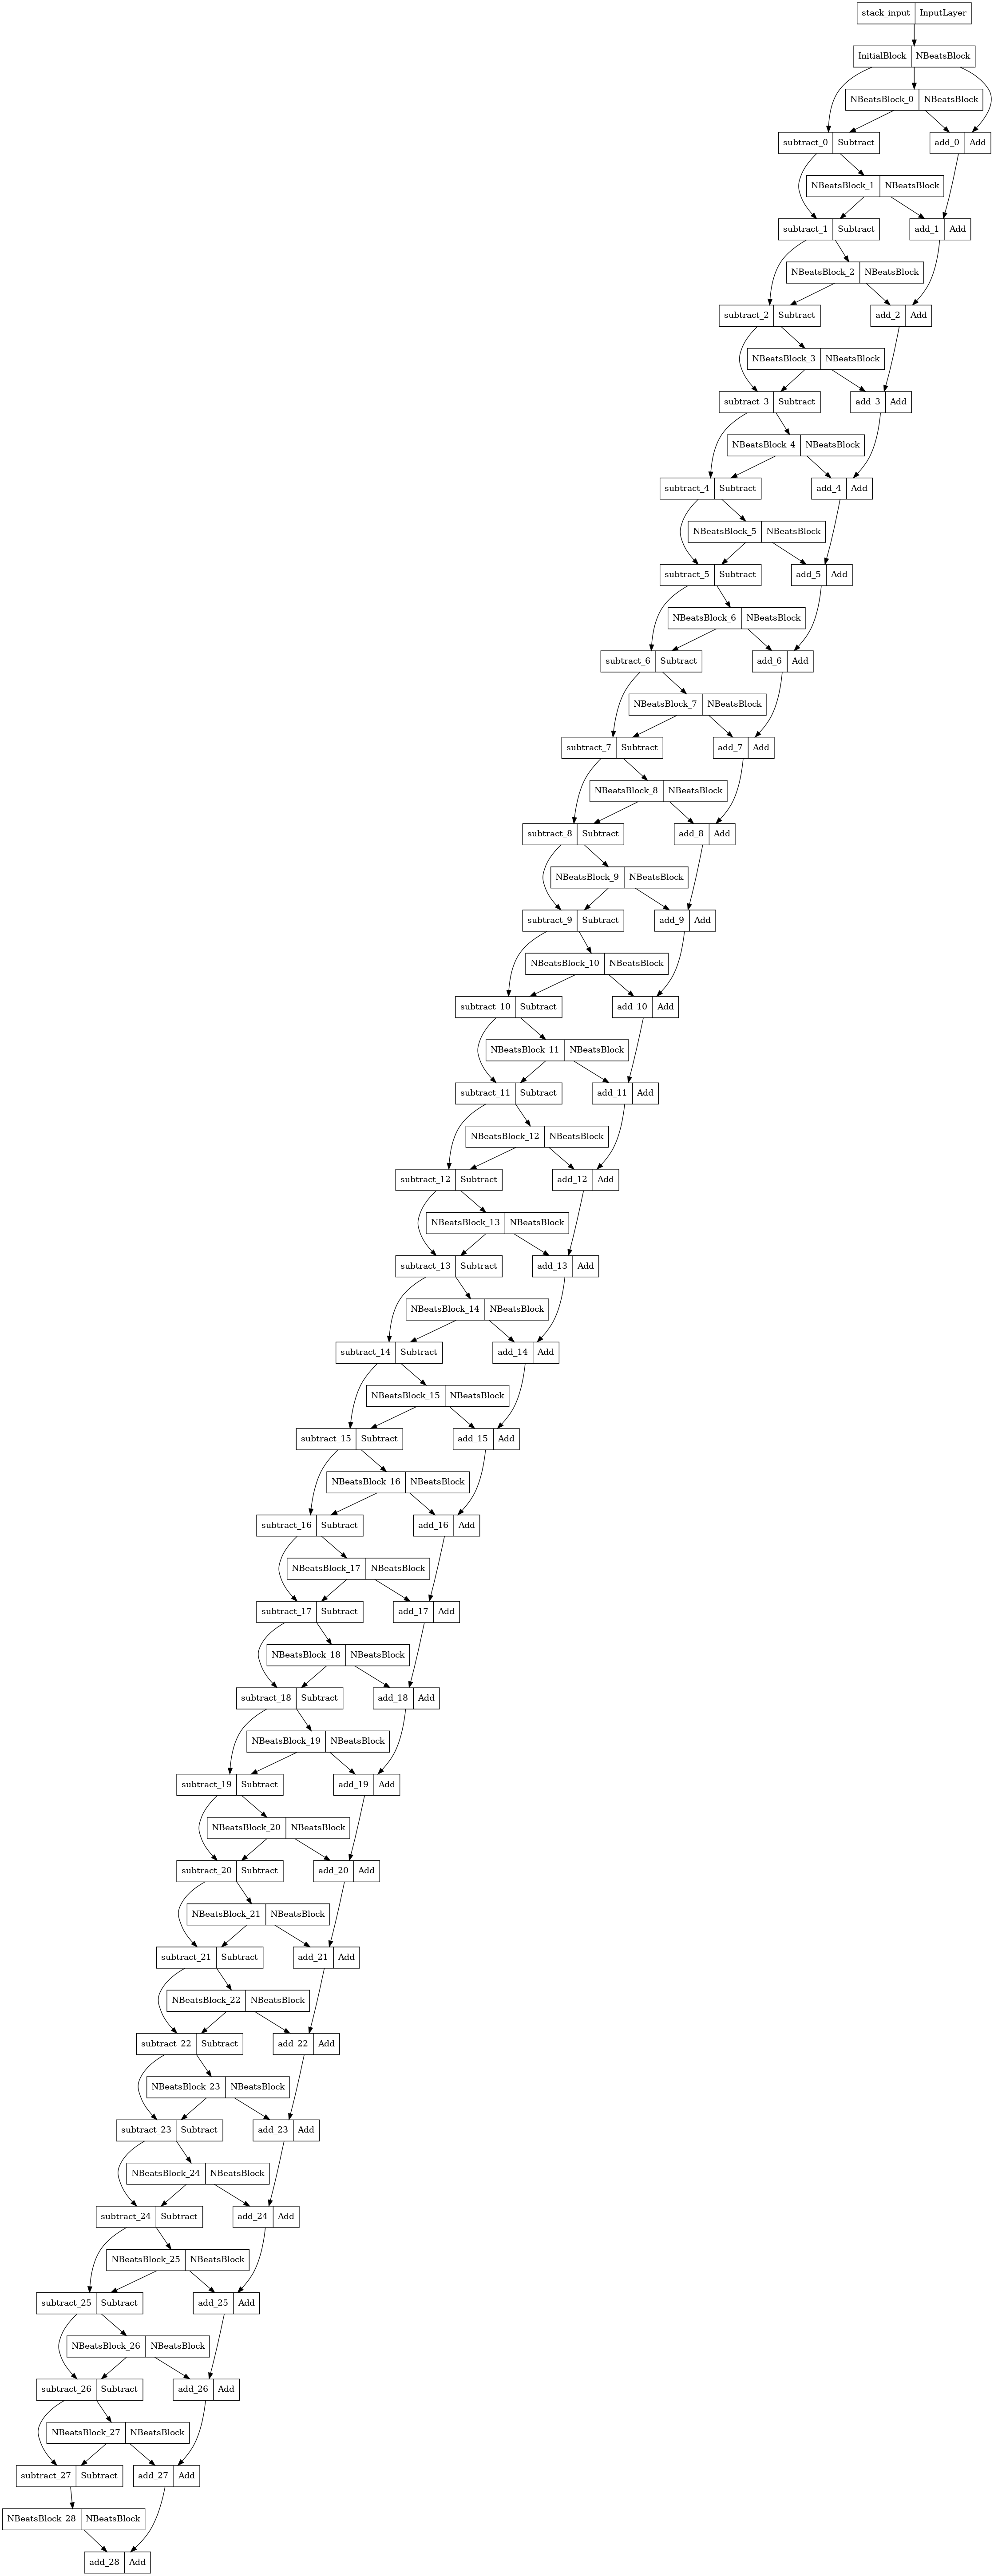

In [179]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal.

In [180]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting and ensemble of models (using different loss functions)